In [1]:
import sys
import datetime as dt
from copy import deepcopy
from os import getcwd
from os.path import dirname, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import scipy.linalg as la
from scipy import interpolate

PROJ_DIR = dirname(getcwd())
sys.path.append(PROJ_DIR)

SRC_DIR = join(PROJ_DIR, 'MAMMAL')
DATA_DIR = join(PROJ_DIR, 'data')
TEST_DIR = join(DATA_DIR, 'test')

from MAMMAL.Utils import ProcessingUtils as pu
from MAMMAL.Utils import Filters
from MAMMAL.VehicleCal import magUtilsTL as magtl


%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 30) # (w, h)
pd.set_option('mode.chained_assignment', None)


SURVEY_DIR = r'C:\Users\ltber\Desktop\files\AFIT\Research\WPAFB_Survey\data\flight_data\static_tolles_lawson'

LOG_CSV_FNAME = 'project_20221014_15_39_37_converted_log.csv'
CAL_NAME      = 'MFAM Sensor Head 1 Ground Tolles Lawson'


def precal_plots(timestamps, b_scalar, mfam_vec_dcs, vmr_dcs):
    _, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(7, 1, sharex=True)

    ax0.plot(timestamps, b_scalar)
    ax0.set_title('Sensor Head 2 Measurements (Inside UAV)')
    ax0.set_ylabel('nT')
    ax0.set_xlabel('Timestamp')
    ax0.grid()

    ax1.plot(timestamps, mfam_vec_dcs[:, 0])
    ax1.set_title('MFAM Direction Cosines X-Component (Inside UAV)')
    ax1.set_xlabel('Timestamp')
    ax1.grid()

    ax2.plot(timestamps, mfam_vec_dcs[:, 1])
    ax2.set_title('MFAM Direction Cosines Y-Component (Inside UAV)')
    ax2.set_xlabel('Timestamp')
    ax2.grid()

    ax3.plot(timestamps, mfam_vec_dcs[:, 2])
    ax3.set_title('MFAM Direction Cosines Z-Component (Inside UAV)')
    ax3.set_xlabel('Timestamp')
    ax3.grid()

    ax4.plot(timestamps, vmr_dcs[:, 0])
    ax4.set_title('VMR Direction Cosines X-Component (Inside UAV)')
    ax4.set_xlabel('Timestamp')
    ax4.grid()

    ax5.plot(timestamps, vmr_dcs[:, 1])
    ax5.set_title('VMR Direction Cosines Y-Component (Inside UAV)')
    ax5.set_xlabel('Timestamp')
    ax5.grid()

    ax6.plot(timestamps, vmr_dcs[:, 2])
    ax6.set_title('VMR Direction Cosines Z-Component (Inside UAV)')
    ax6.set_xlabel('Timestamp')
    ax6.grid()

def postcal_plots(scalar_ts, b_scalar, b_scalar_truth, cal_scalar, dcs):
    _, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, 1, sharex=True)

    ax0.plot(scalar_ts, b_scalar)
    ax0.plot(scalar_ts, b_scalar_truth, label='Truth')
    ax0.set_title('Uncalibrated Sensor Head 2 Scalar Measurements with Truth (Inside UAV)')
    ax0.set_ylabel('nT')
    ax0.set_xlabel('Timestamp')
    ax0.legend()
    ax0.grid()

    ax1.plot(scalar_ts, cal_scalar)
    ax1.plot(scalar_ts, b_scalar_truth, label='Truth')
    ax1.set_title('Calibrated Sensor Head 2 Scalar Measurements with Truth (Inside UAV)')
    ax1.set_ylabel('nT')
    ax1.set_xlabel('Timestamp')
    ax1.legend()
    ax1.grid()

    ax2.plot(scalar_ts, cal_scalar)
    ax2.set_title('Calibrated Sensor Head 2 Scalar Measurements without Truth (Inside UAV)')
    ax2.set_ylabel('nT')
    ax2.set_xlabel('Timestamp')
    ax2.grid()

    ax3.plot(scalar_ts, dcs[:, 0])
    ax3.set_title('Direction Cosines X-Component Measurements (Inside UAV)')
    ax3.set_xlabel('Timestamp')
    ax3.grid()

    ax4.plot(scalar_ts, dcs[:, 1])
    ax4.set_title('Direction Cosines Y-Component Measurements (Inside UAV)')
    ax4.set_xlabel('Timestamp')
    ax4.grid()

    ax5.plot(scalar_ts, dcs[:, 2])
    ax5.set_title('Direction Cosines Z-Component Measurements (Inside UAV)')
    ax5.set_xlabel('Timestamp')
    ax5.grid()

# Load Calibration Data

In [2]:
log_df = pd.read_csv(join(SURVEY_DIR, LOG_CSV_FNAME), parse_dates=['datetime'])

start_dt = pd.datetime(2022, 10, 14, 15, 42, 30)
end_dt   = pd.datetime(2022, 10, 14, 15, 44, 30)
log_df   = log_df[(log_df.datetime > start_dt) & (log_df.datetime < end_dt)]

datetimes  = log_df.datetime
timestamps = np.array(log_df.epoch_sec)

C:\Users\ltber\AppData\Local\Temp\ipykernel_56552\3279595010.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_dt = pd.datetime(2022, 10, 14, 15, 42, 30)
C:\Users\ltber\AppData\Local\Temp\ipykernel_56552\3279595010.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_dt   = pd.datetime(2022, 10, 14, 15, 44, 30)


# Calibrate MFAM Sensor Head 2 in the Airplane

# Prune/Preprocess Data

In [3]:
interp_mfam_x = interpolate.interp1d(timestamps[log_df.SCALAR_2_VALID],
                                     log_df.SCALAR_2[log_df.SCALAR_2_VALID],
                                     'linear',
                                     fill_value='extrapolate')
b_scalar = Filters.lpf(interp_mfam_x(timestamps), 10, 1000, 4)

vmr = np.hstack([np.array(log_df.X)[:, np.newaxis], 
                 np.array(log_df.Y)[:, np.newaxis],
                 np.array(log_df.Z)[:, np.newaxis]])
vmr_magnitude = la.norm(vmr, axis=1)
vmr_dcs = vmr / vmr_magnitude[:, np.newaxis]

mfam_vec = np.hstack([np.array(log_df.X_MFAM)[:, np.newaxis], 
                      np.array(log_df.Y_MFAM)[:, np.newaxis],
                      np.array(log_df.Z_MFAM)[:, np.newaxis]])
mfam_vec_magnitude = la.norm(mfam_vec, axis=1)
mfam_vec_dcs = mfam_vec / mfam_vec_magnitude[:, np.newaxis]

# Pre-Calibration Plots

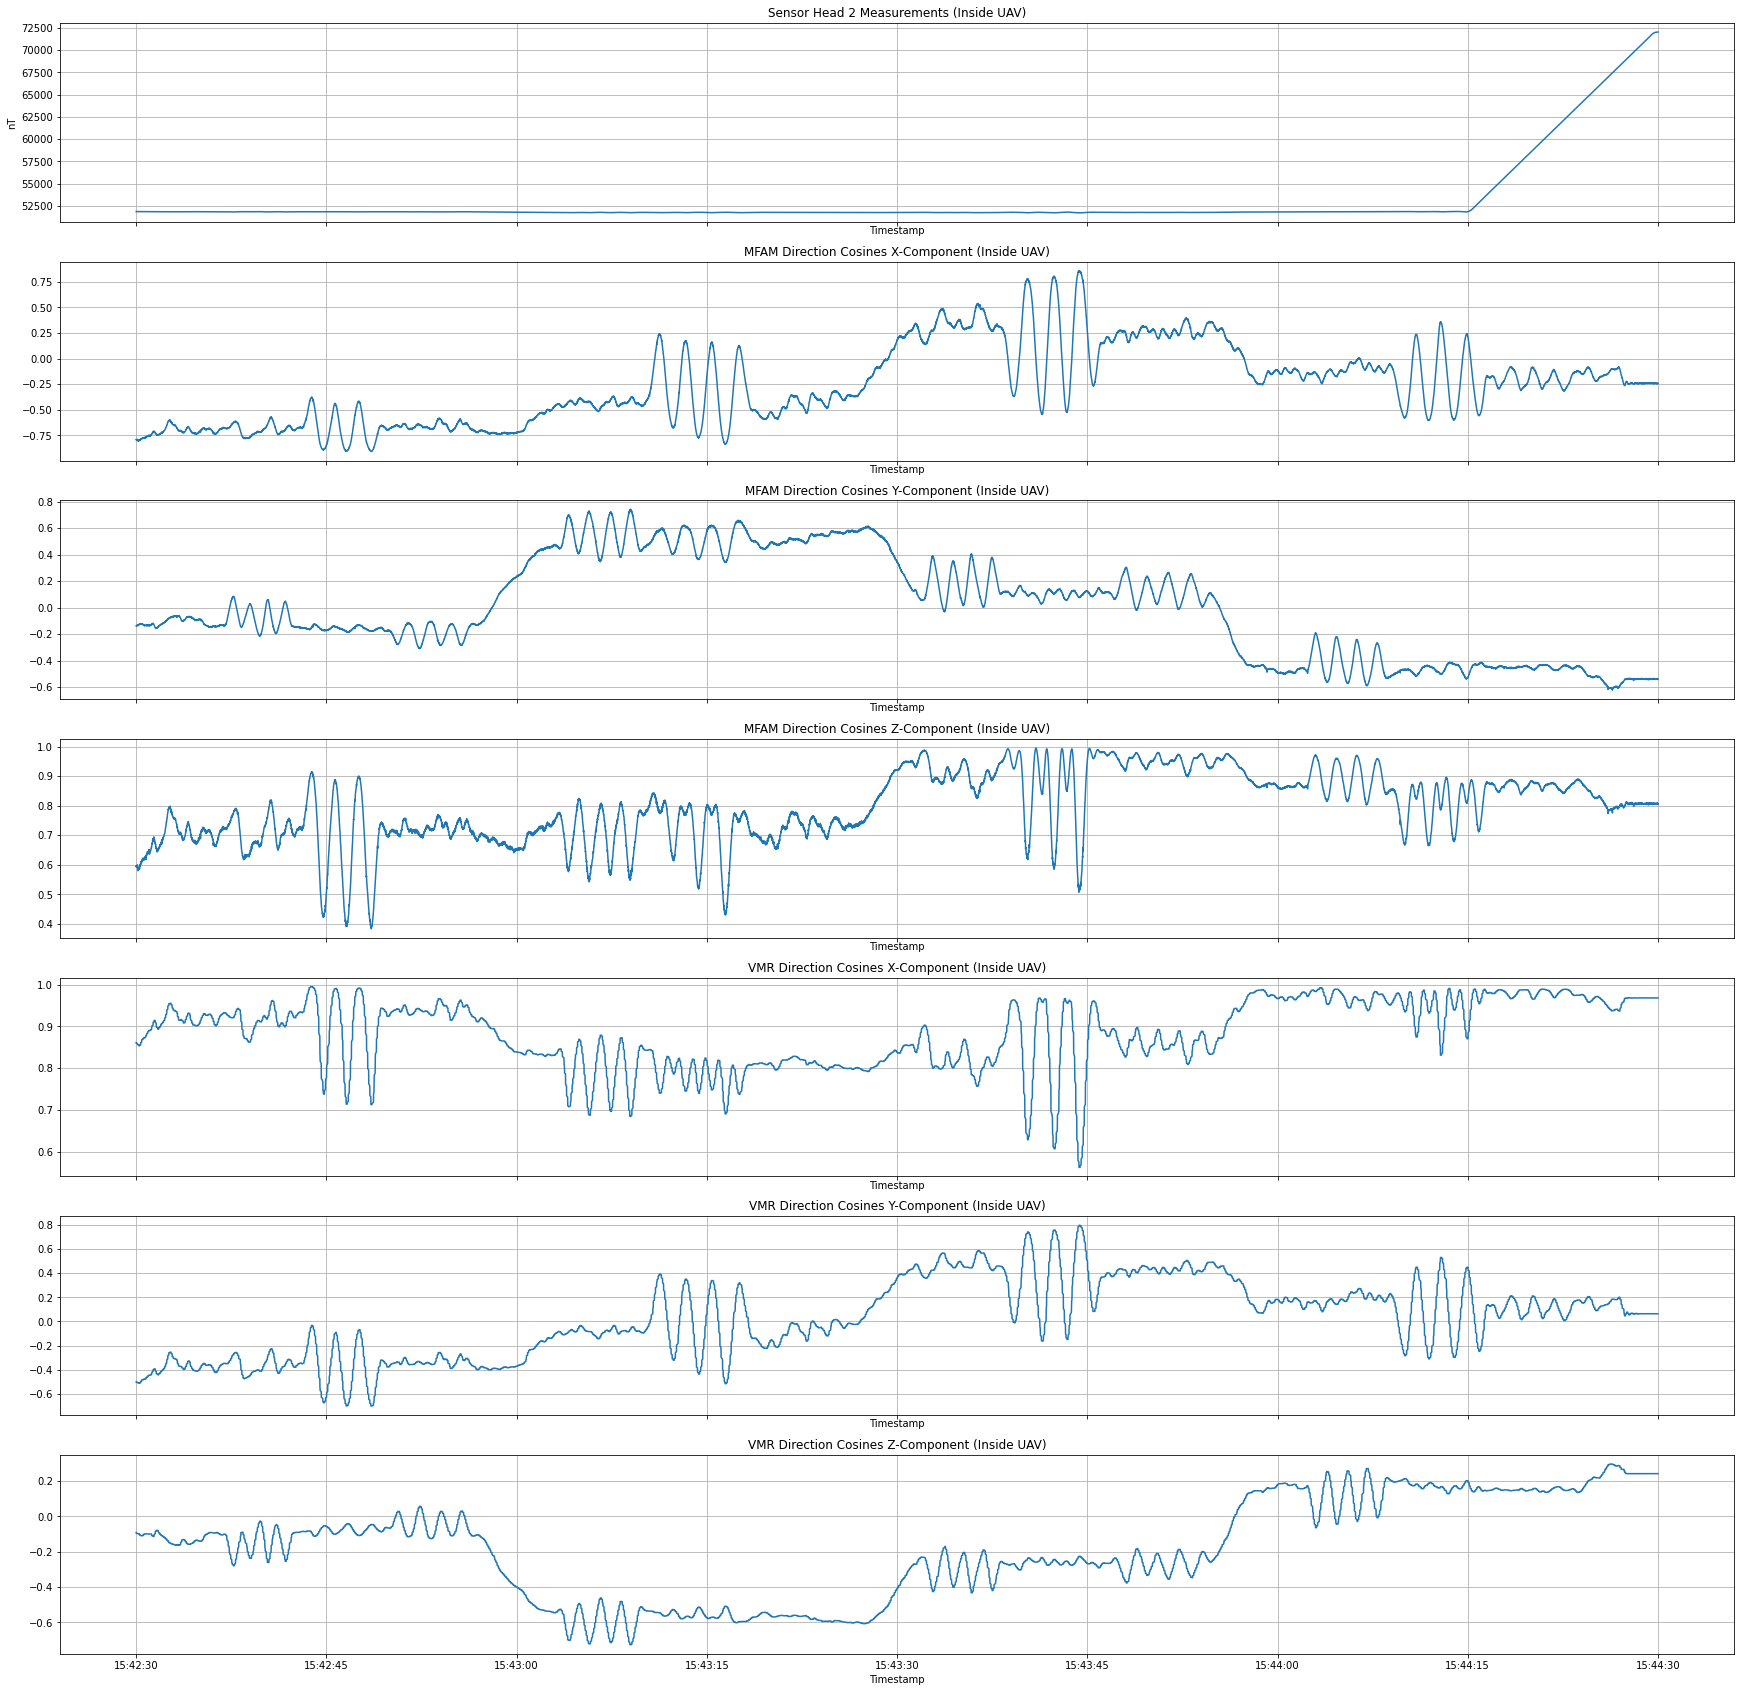

In [4]:
precal_plots(datetimes,
             b_scalar,
             mfam_vec_dcs,
             vmr_dcs)

# Find/Apply Tolles Lawson (TL) Calibration Coefficients (All TL Terms + MFAM Vector Sensor)

In [5]:
tl_terms = magtl.DEFAULT_TL_TERMS

b_vector = mfam_vec

scalar_ts = timestamps
delta_t     = np.diff(scalar_ts).mean()

filt = magtl.Filter(order = 10,
                    fcut  = [0.1, 2.0],
                    btype = 'band',
                    ftype = 'butter',
                    fs    = (1.0 / delta_t))

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 5.03998851e+02  6.62622786e+02  5.38513511e+02  5.74740229e+06
 -2.30310601e+05 -4.37546185e+05  5.36689744e+06 -7.75089237e+05
  6.28488083e+06  5.57833245e+08 -2.24540323e+04  9.47667418e+04
 -8.47202583e+04  5.57979217e+08  8.59839095e+04  2.66457135e+04
  3.45619717e+04  5.57976261e+08]
RMSE: 4773.267707127026


# Post-Calibration Plots (All TL Terms + MFAM Vector Sensor)

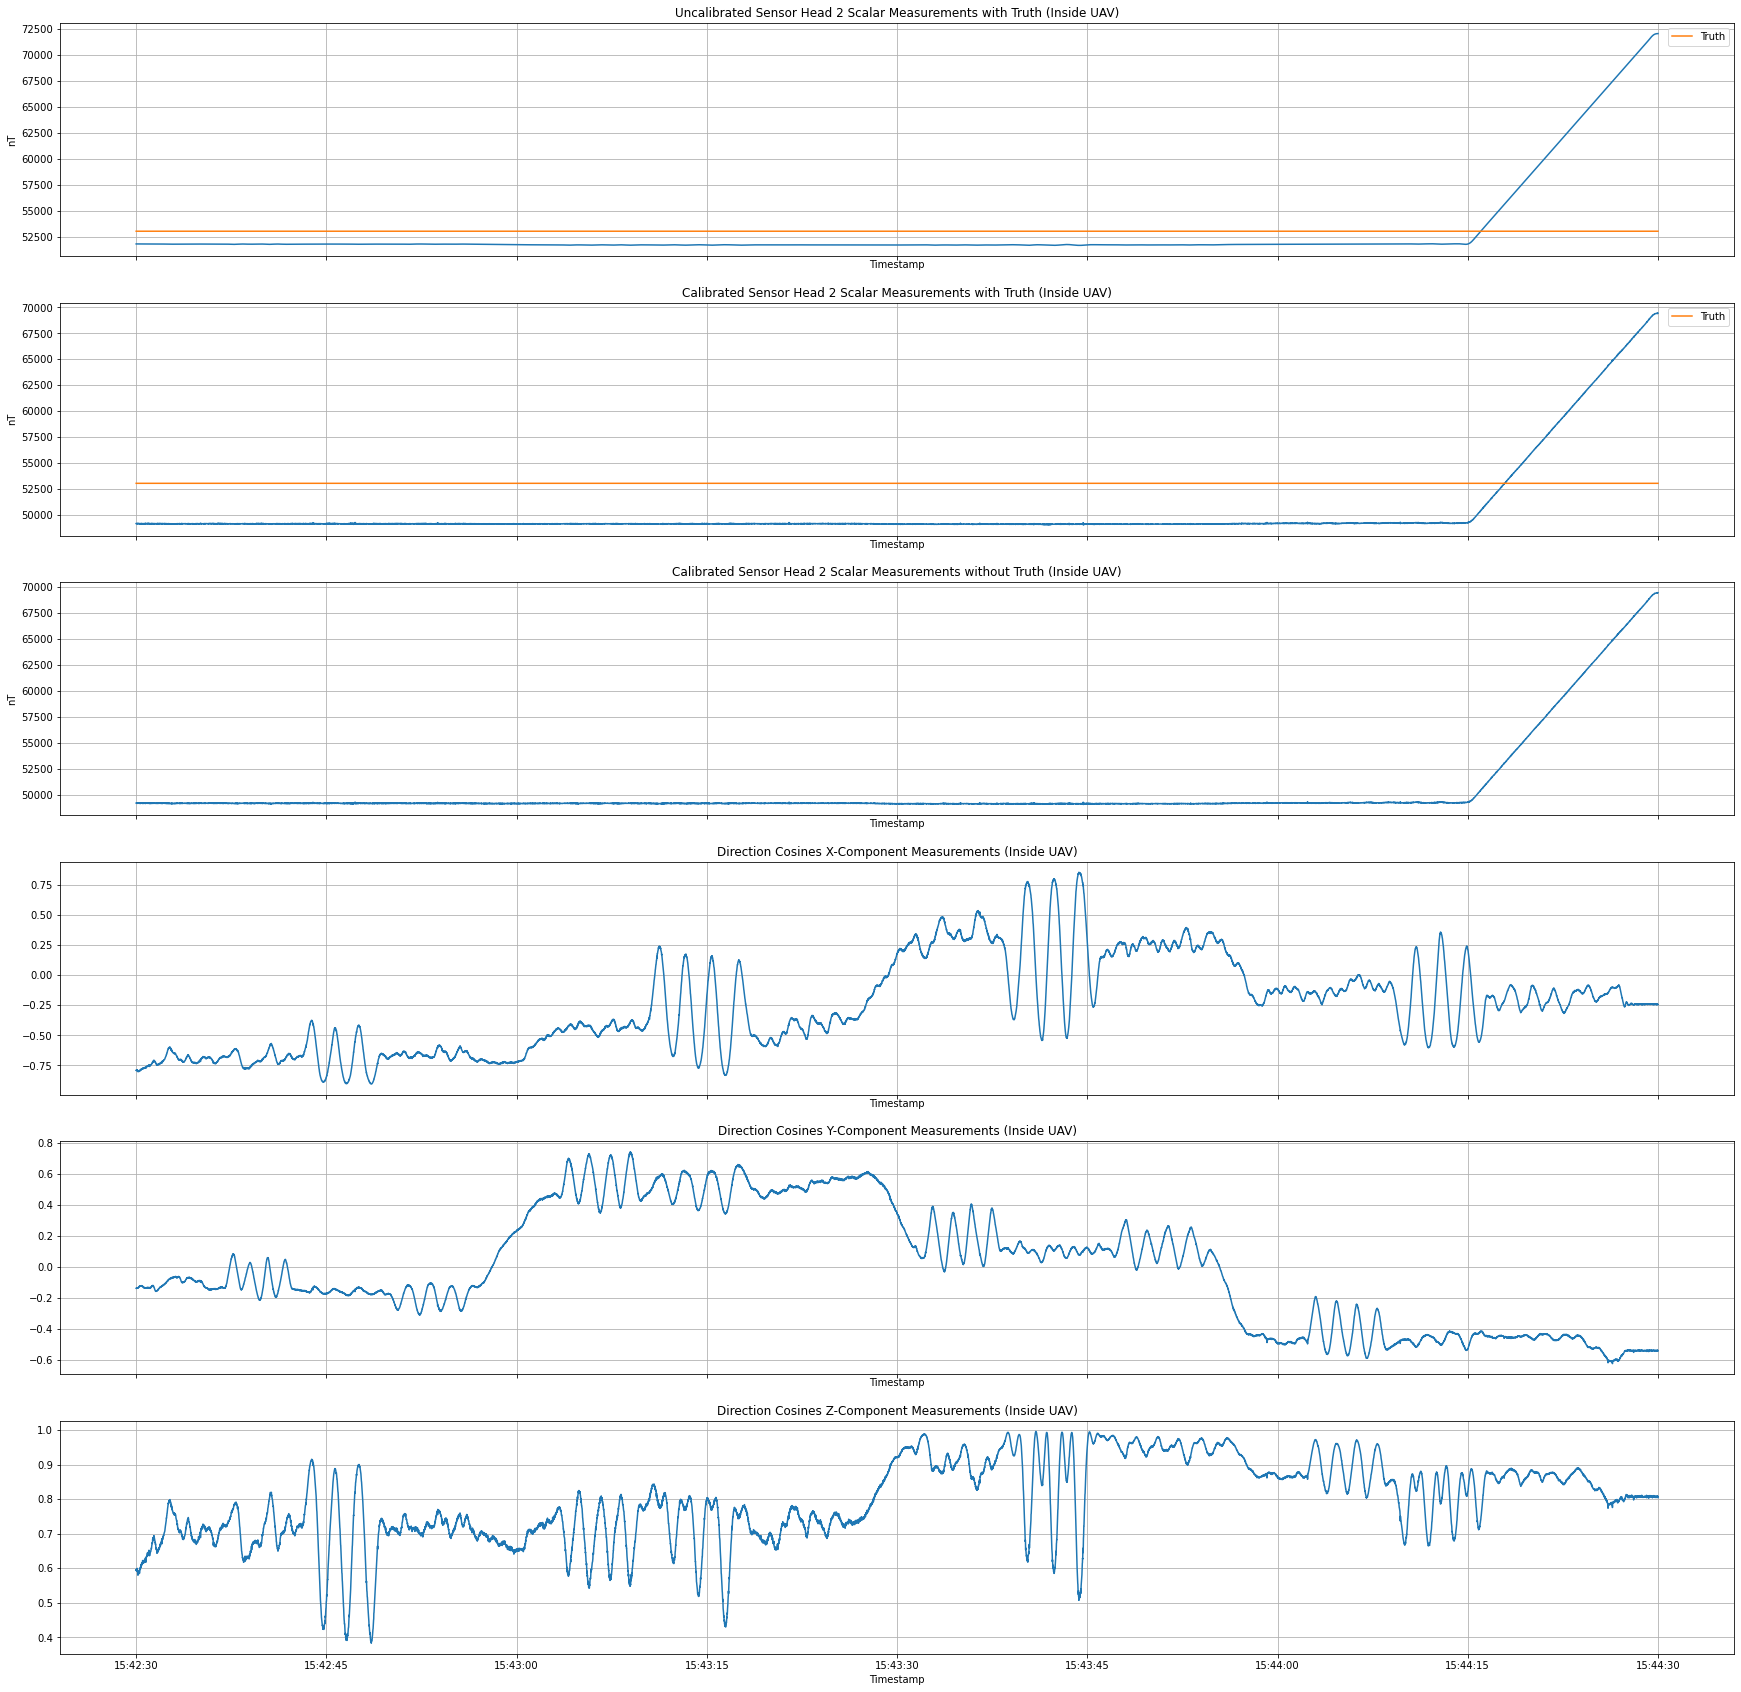

In [6]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Permanent and Induced TL Terms + MFAM Vector Sensor)

In [7]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT,
            magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 1.10069079e+03  1.09829839e+03  1.37385748e+03  1.13251745e+07
 -8.15184942e+05 -1.16443182e+06  1.11129809e+07 -9.01888654e+05
  1.16133329e+07]
RMSE: 6577.568272859337


# Post-Calibration Plots (Permanent and Induced TL Terms + MFAM Vector Sensor)

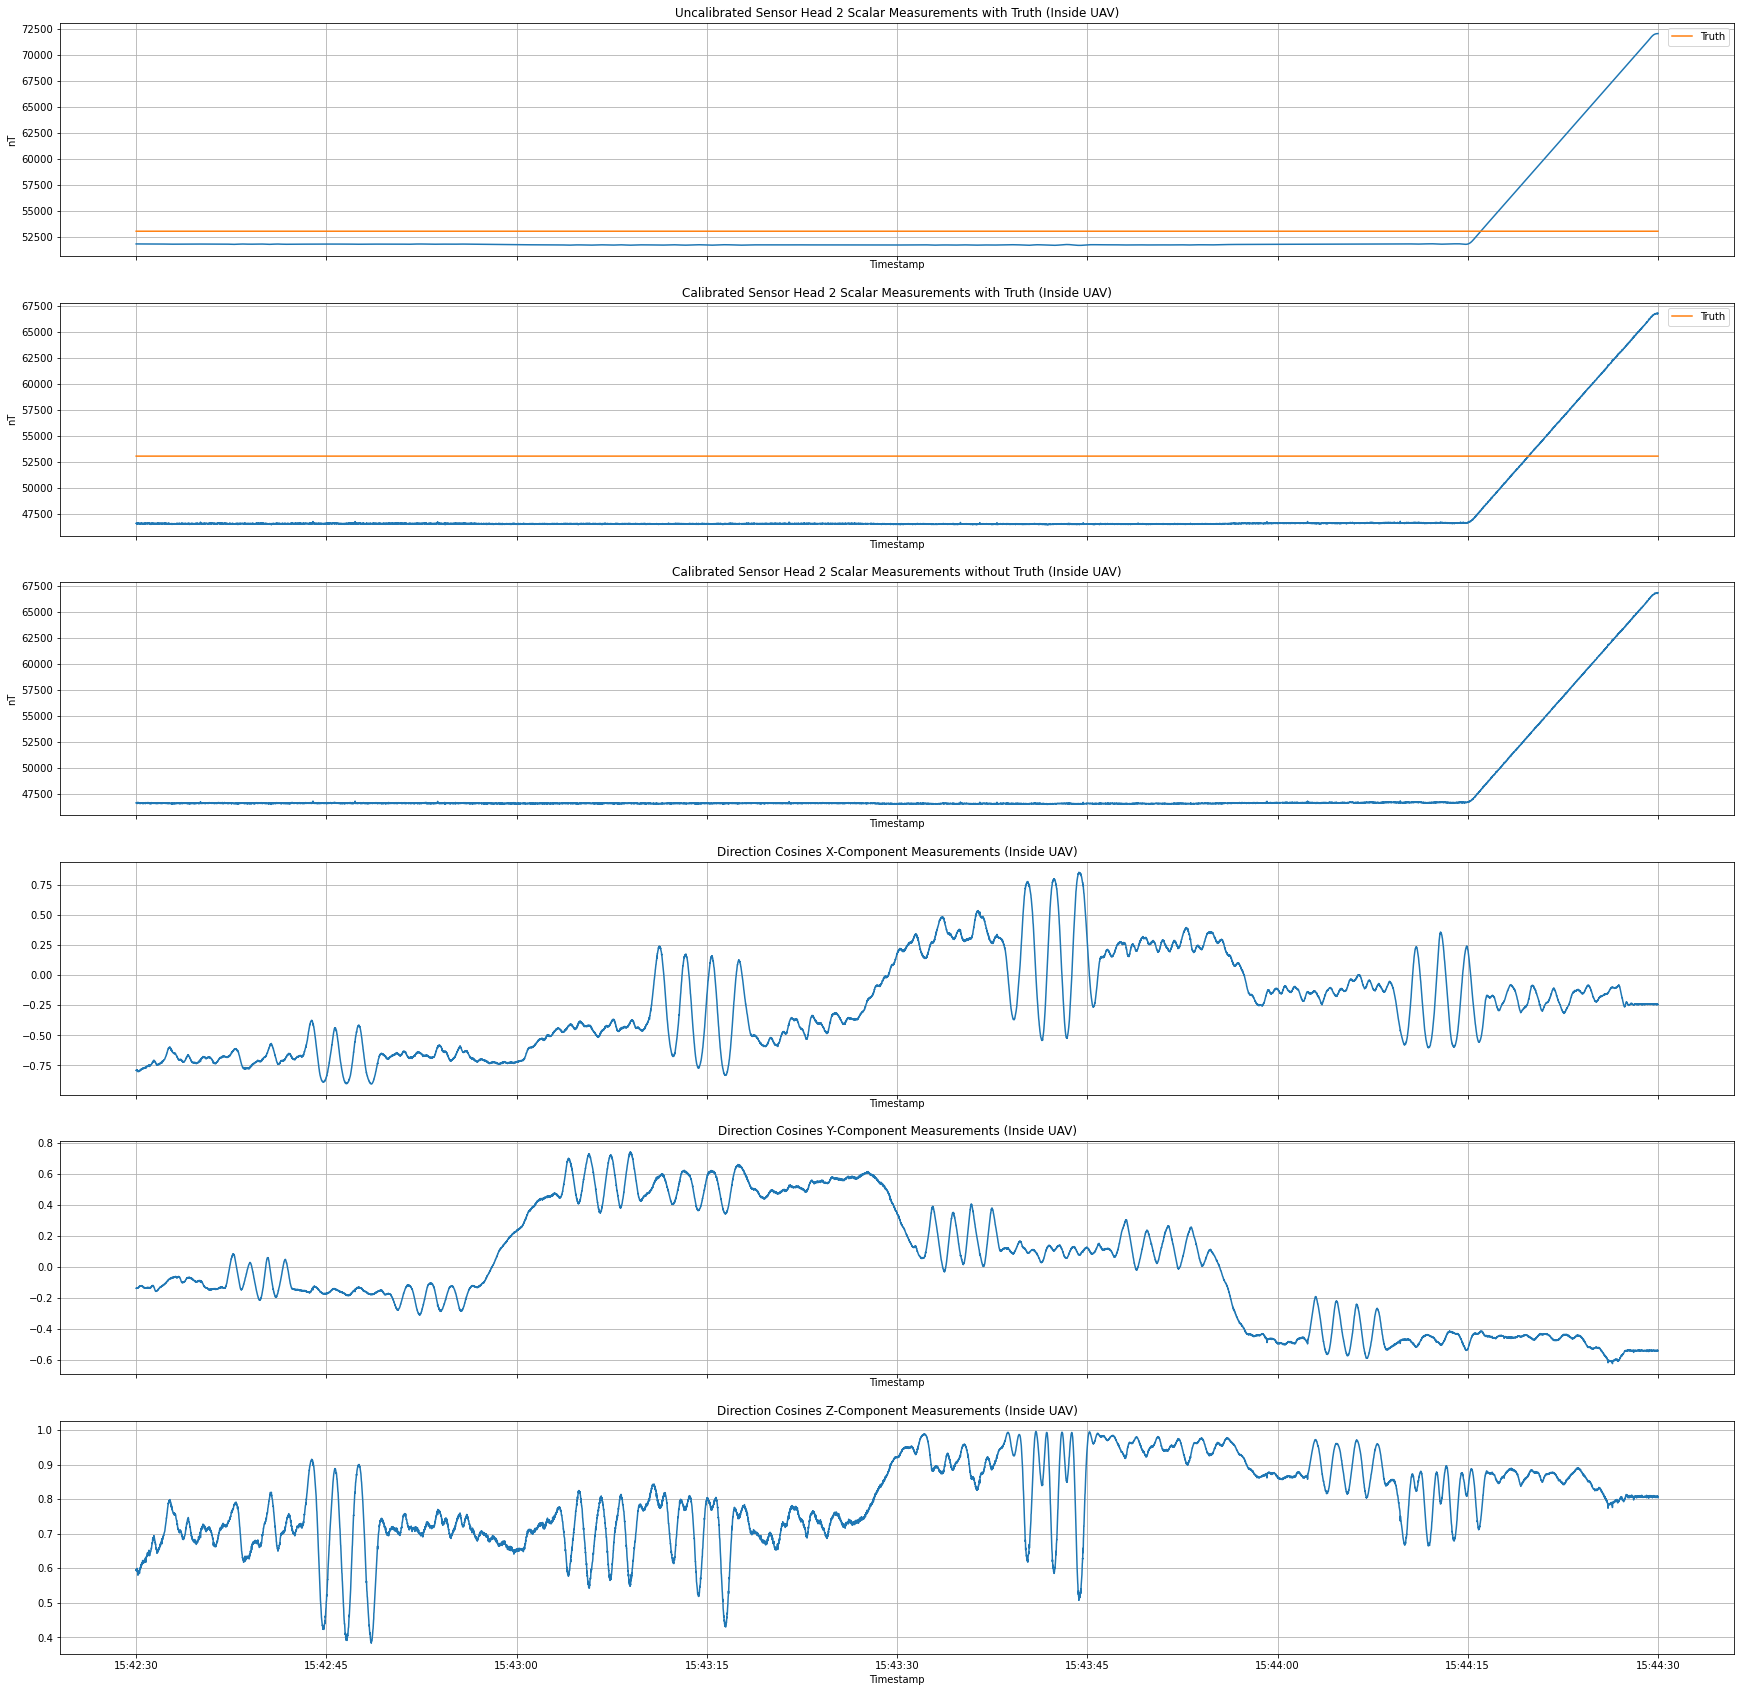

In [8]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Permanent TL Terms + MFAM Vector Sensor)

In [9]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [-45.2181841   -6.8453942   15.99512435]
RMSE: 3993.838376990992


# Post-Calibration Plots (Permanent TL Terms + MFAM Vector Sensor)

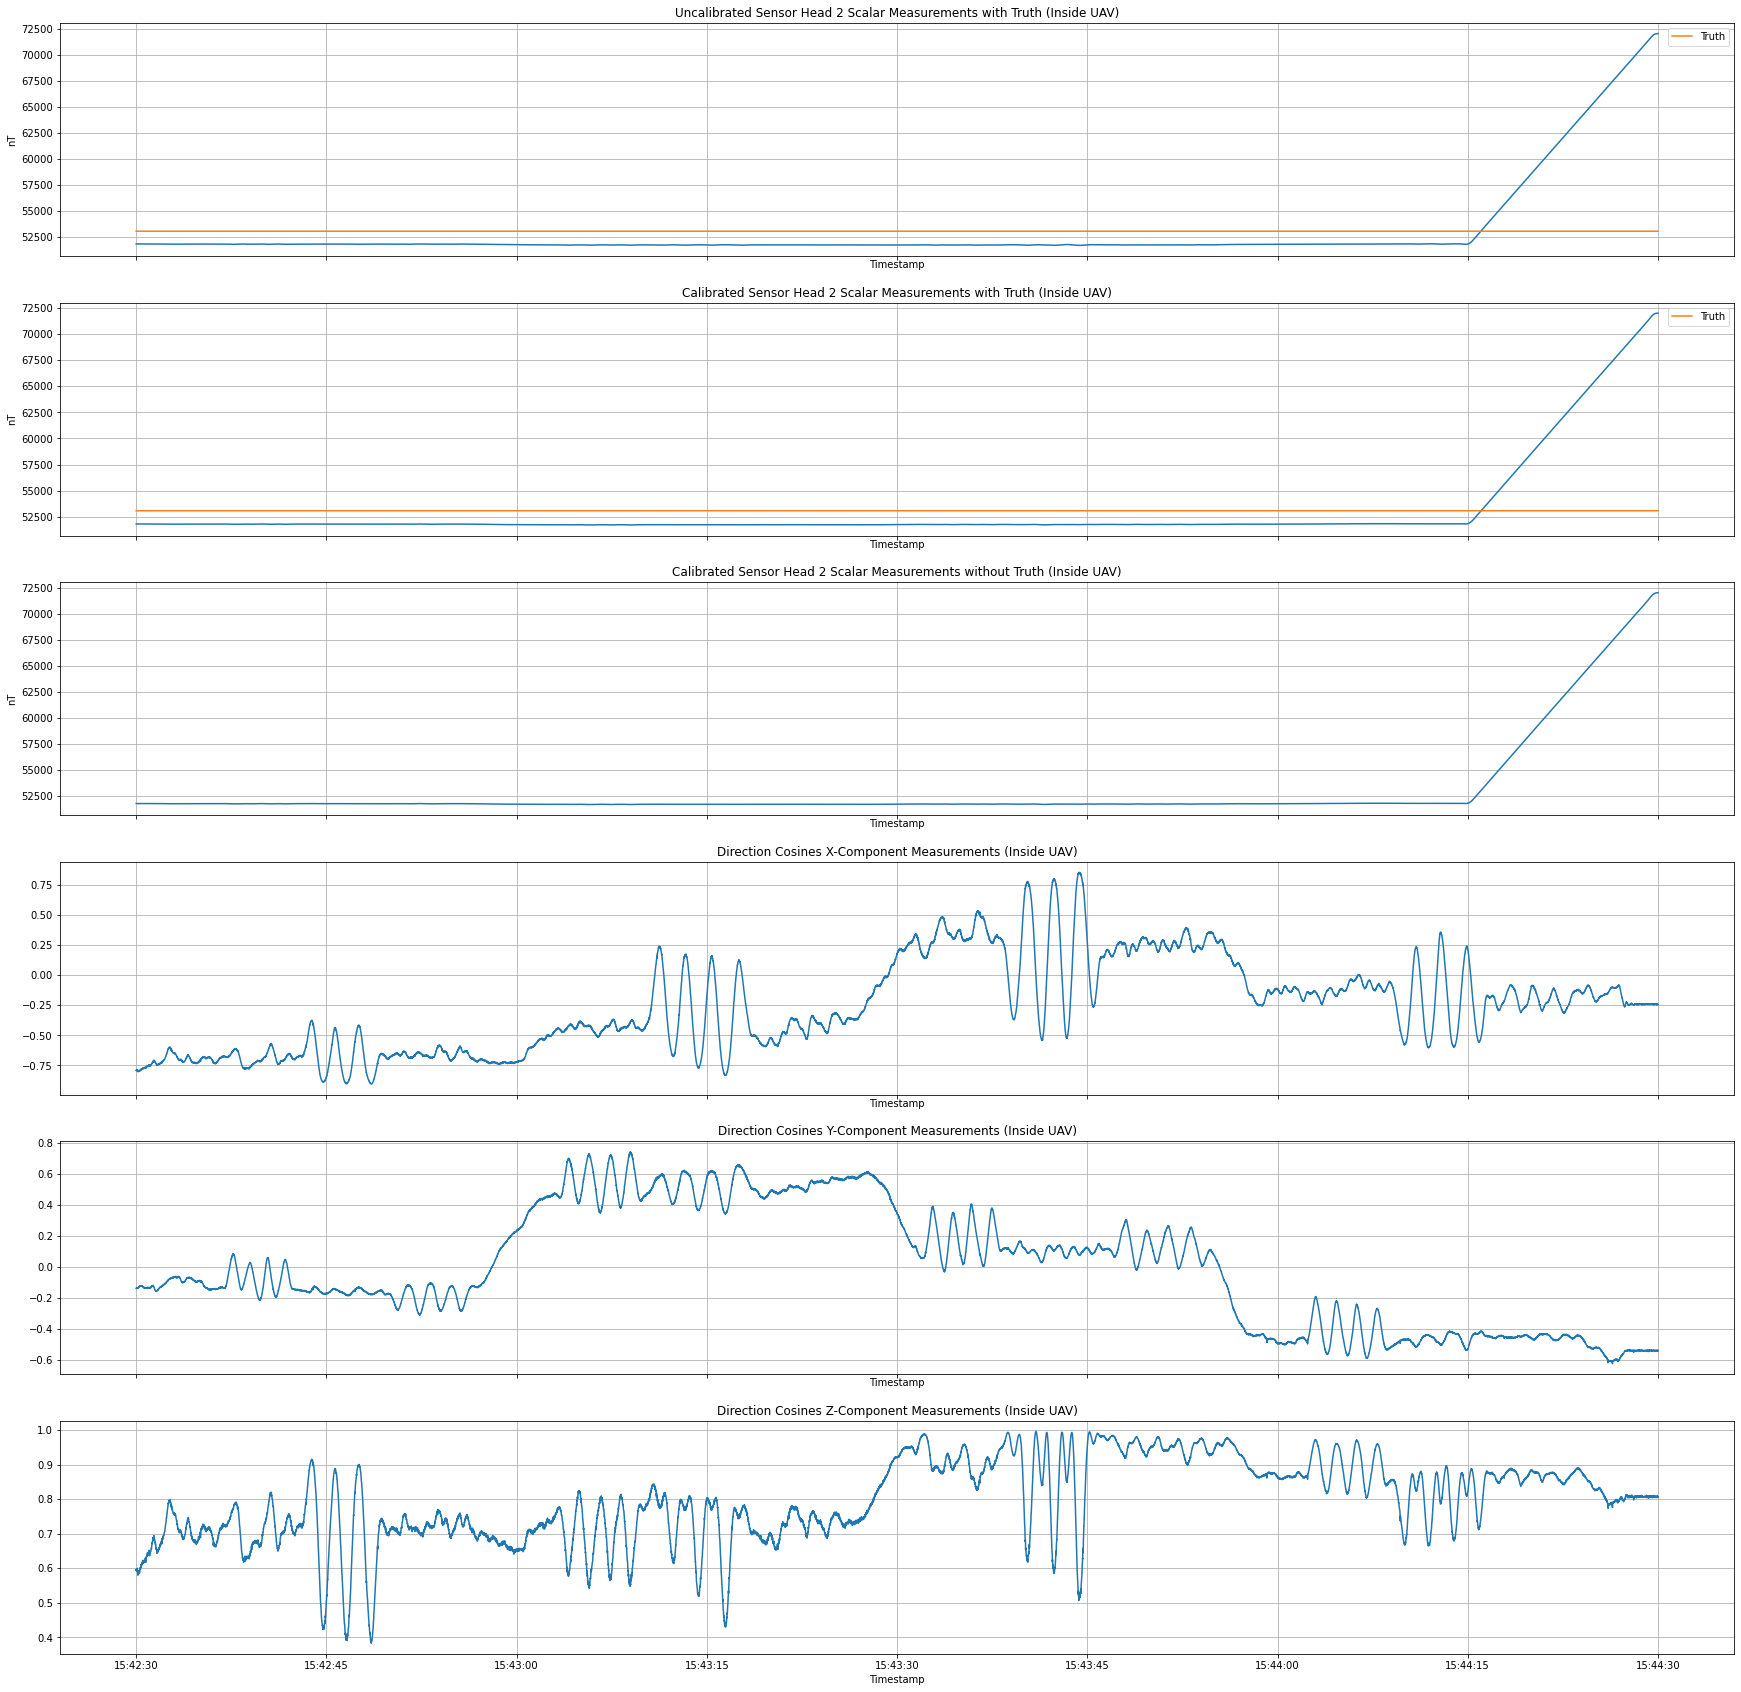

In [10]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Induced TL Terms + MFAM Vector Sensor)

In [11]:
tl_terms = [magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [520529.54868259 139642.19350529   6784.4569092  294011.67841377
 155423.86084133 675069.83703535]
RMSE: 4003.505743649526


# Post-Calibration Plots (Induced TL Terms + MFAM Vector Sensor)

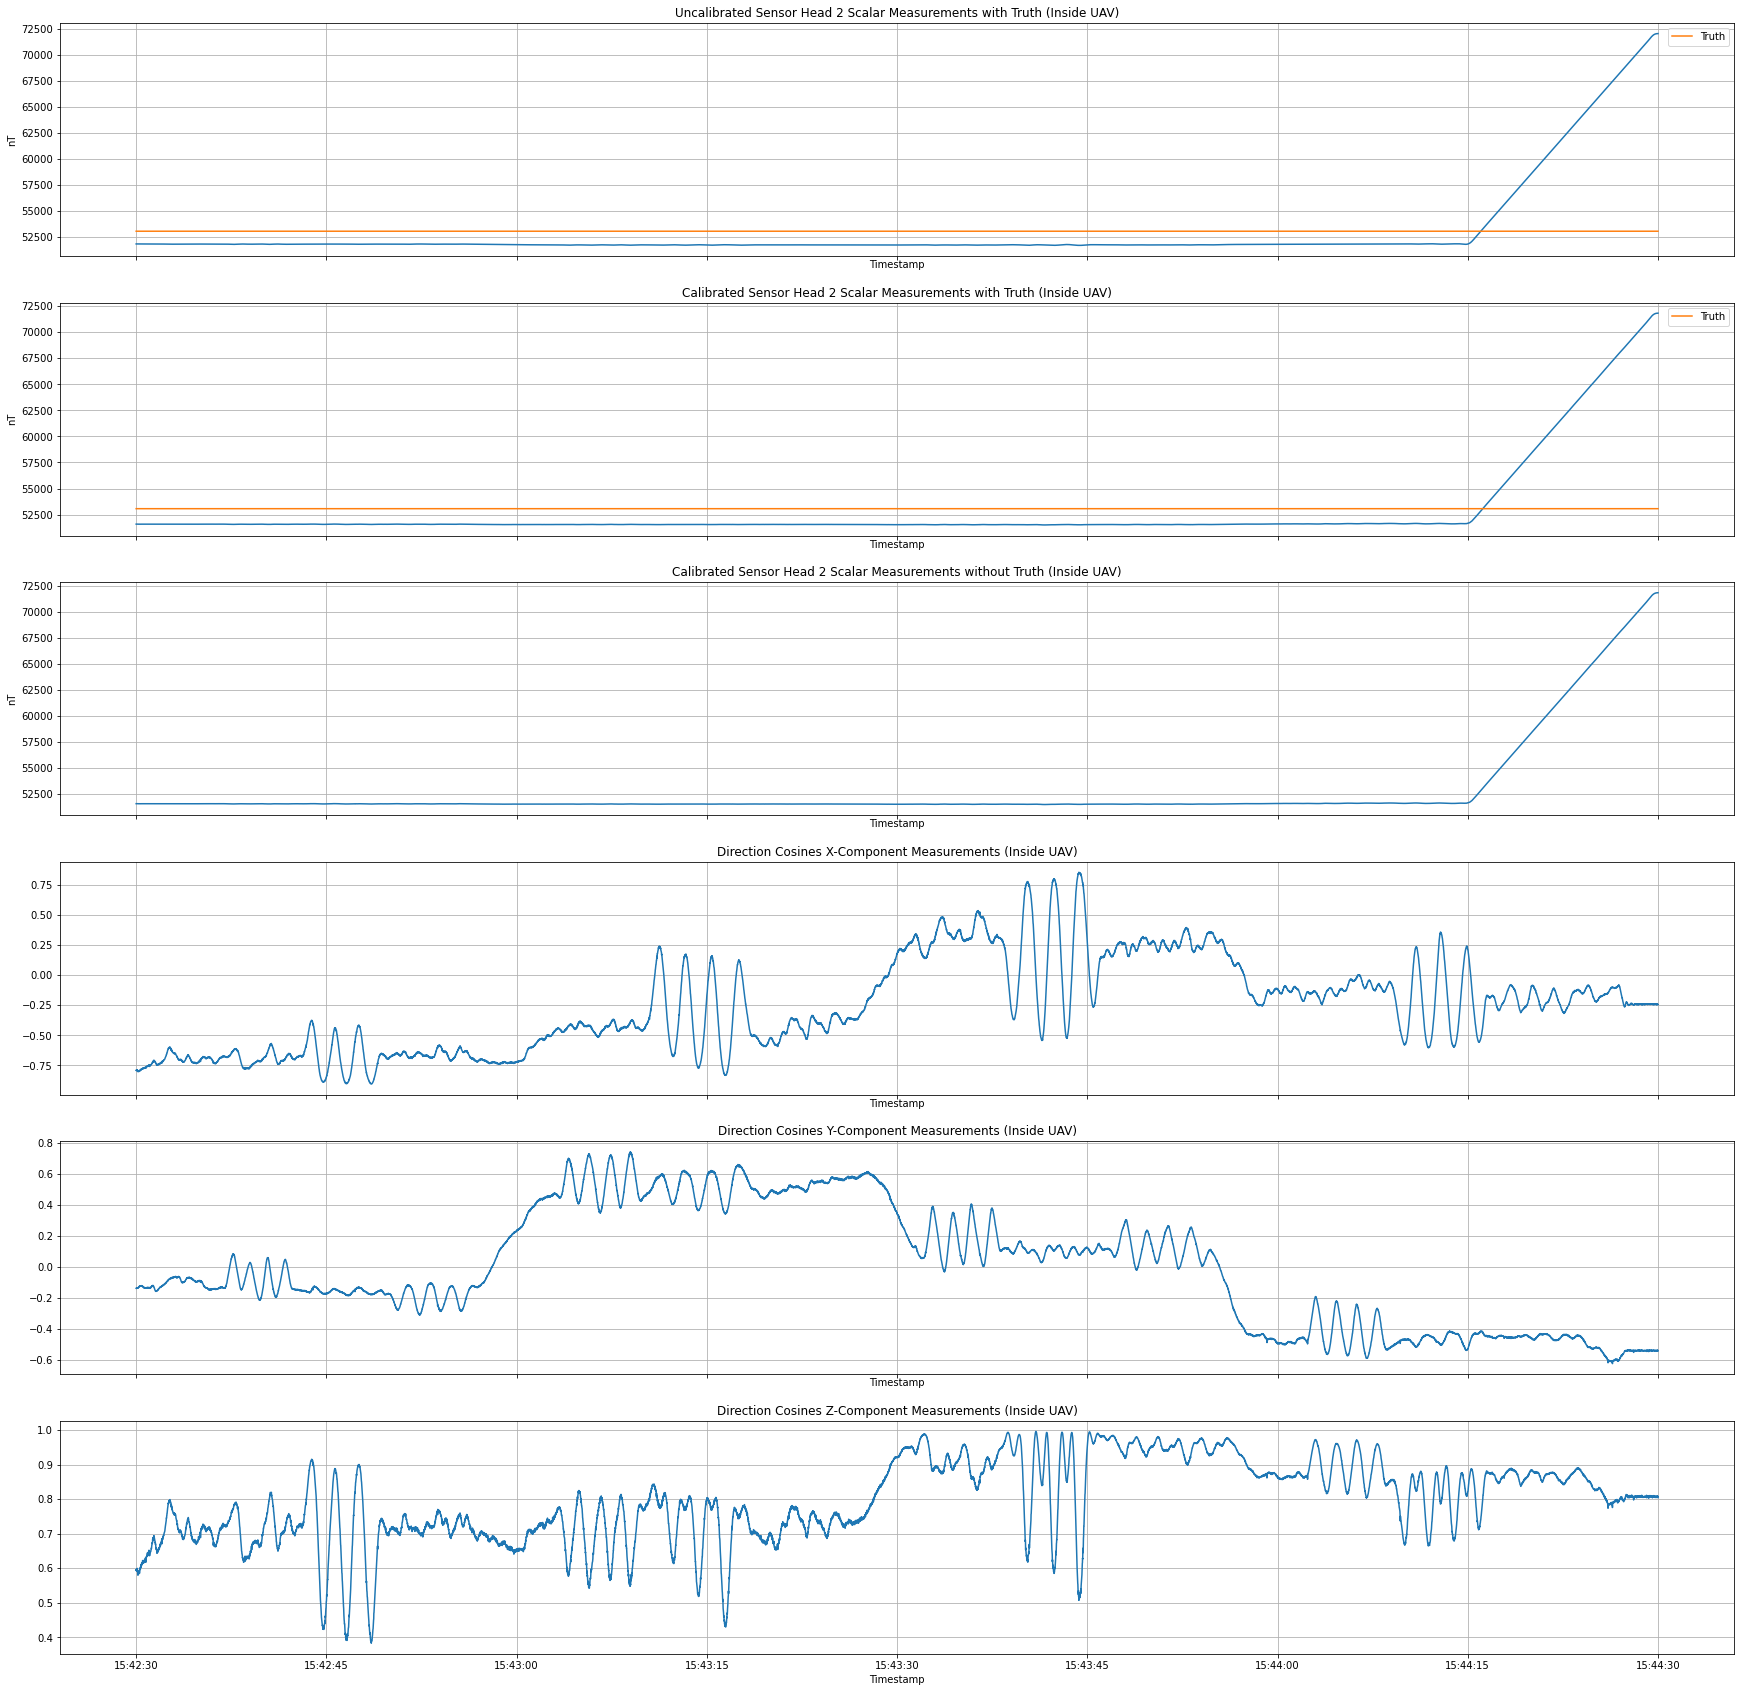

In [12]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Eddy TL Terms + MFAM Vector Sensor)

In [13]:
tl_terms = [magtl.TollesLawsonTerms.EDDY]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 5.32315884e+08 -2.08721560e+04  8.96086372e+04 -8.07808828e+04
  5.32468235e+08  1.01926226e+05  2.68076489e+04  1.54769304e+04
  5.32437361e+08]
RMSE: 3994.221670926114


# Post-Calibration Plots (Eddy TL Terms + MFAM Vector Sensor)

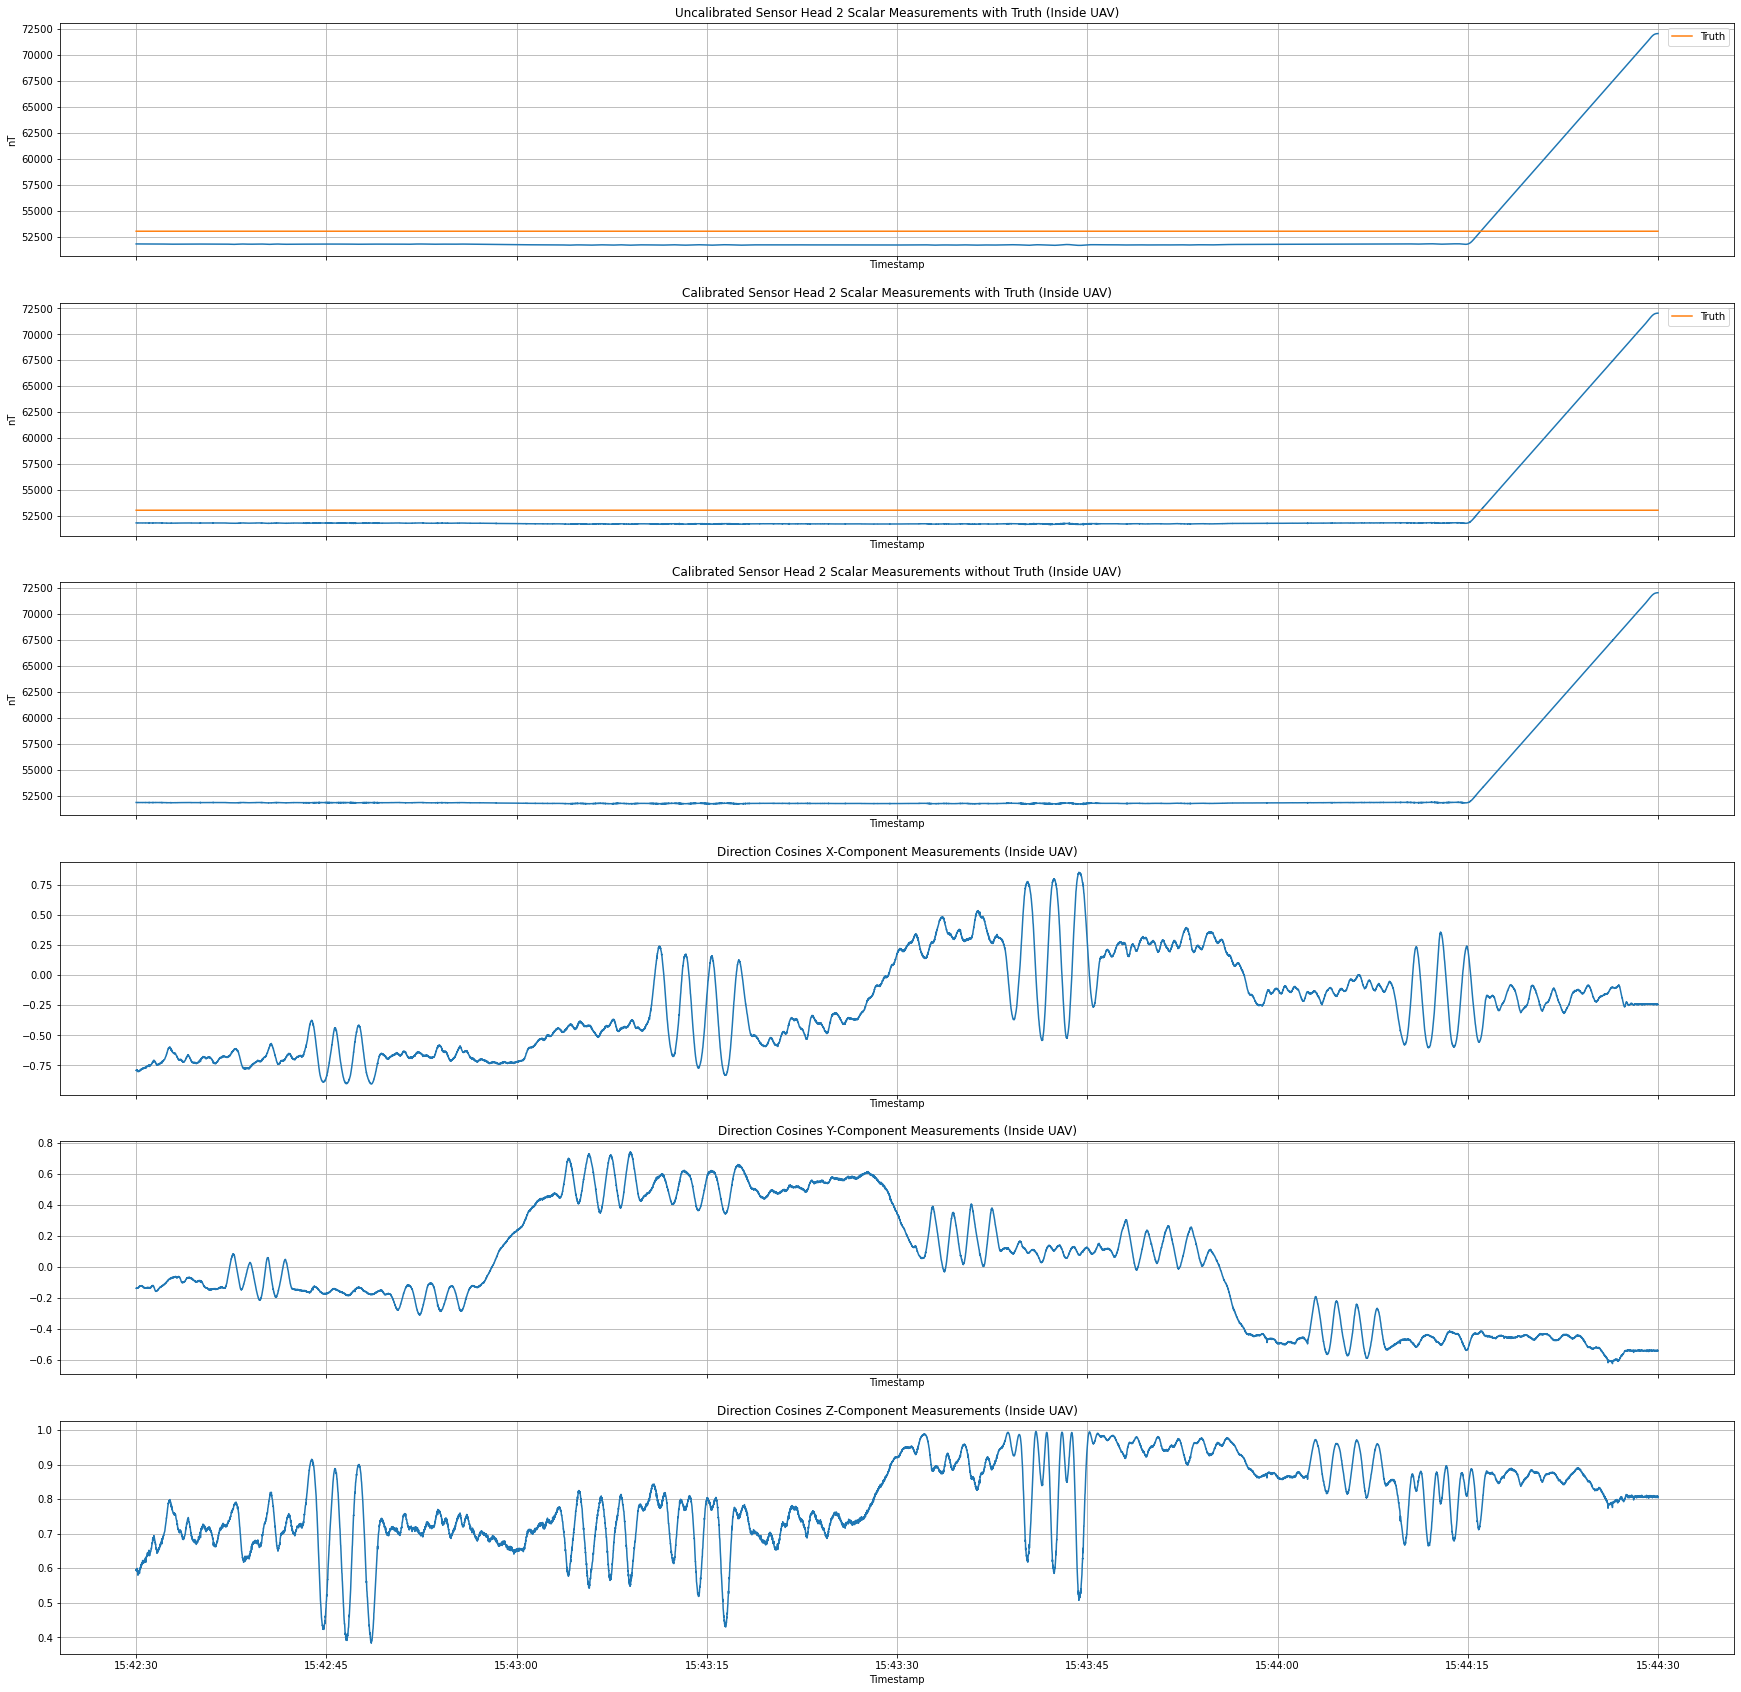

In [14]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply Tolles Lawson (TL) Calibration Coefficients (All TL Terms + VMR Vector Sensor)

In [15]:
tl_terms = magtl.DEFAULT_TL_TERMS

b_vector = vmr

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 8.05240780e+02 -1.05428115e+02 -4.66219537e+00 -4.70513104e-01
  5.29485798e-03 -1.29646600e-03 -4.37043212e-01  1.49704887e-02
 -4.68821334e-01 -2.29109944e-02  2.54108897e-04  6.78362160e-05
  2.96973605e-04 -2.24953874e-02 -1.87583435e-04 -1.18982685e-03
  6.32247041e-04 -2.21487677e-02]
RMSE: 26392.51451087712


# Post-Calibration Plots (All TL Terms + VMR Vector Sensor)

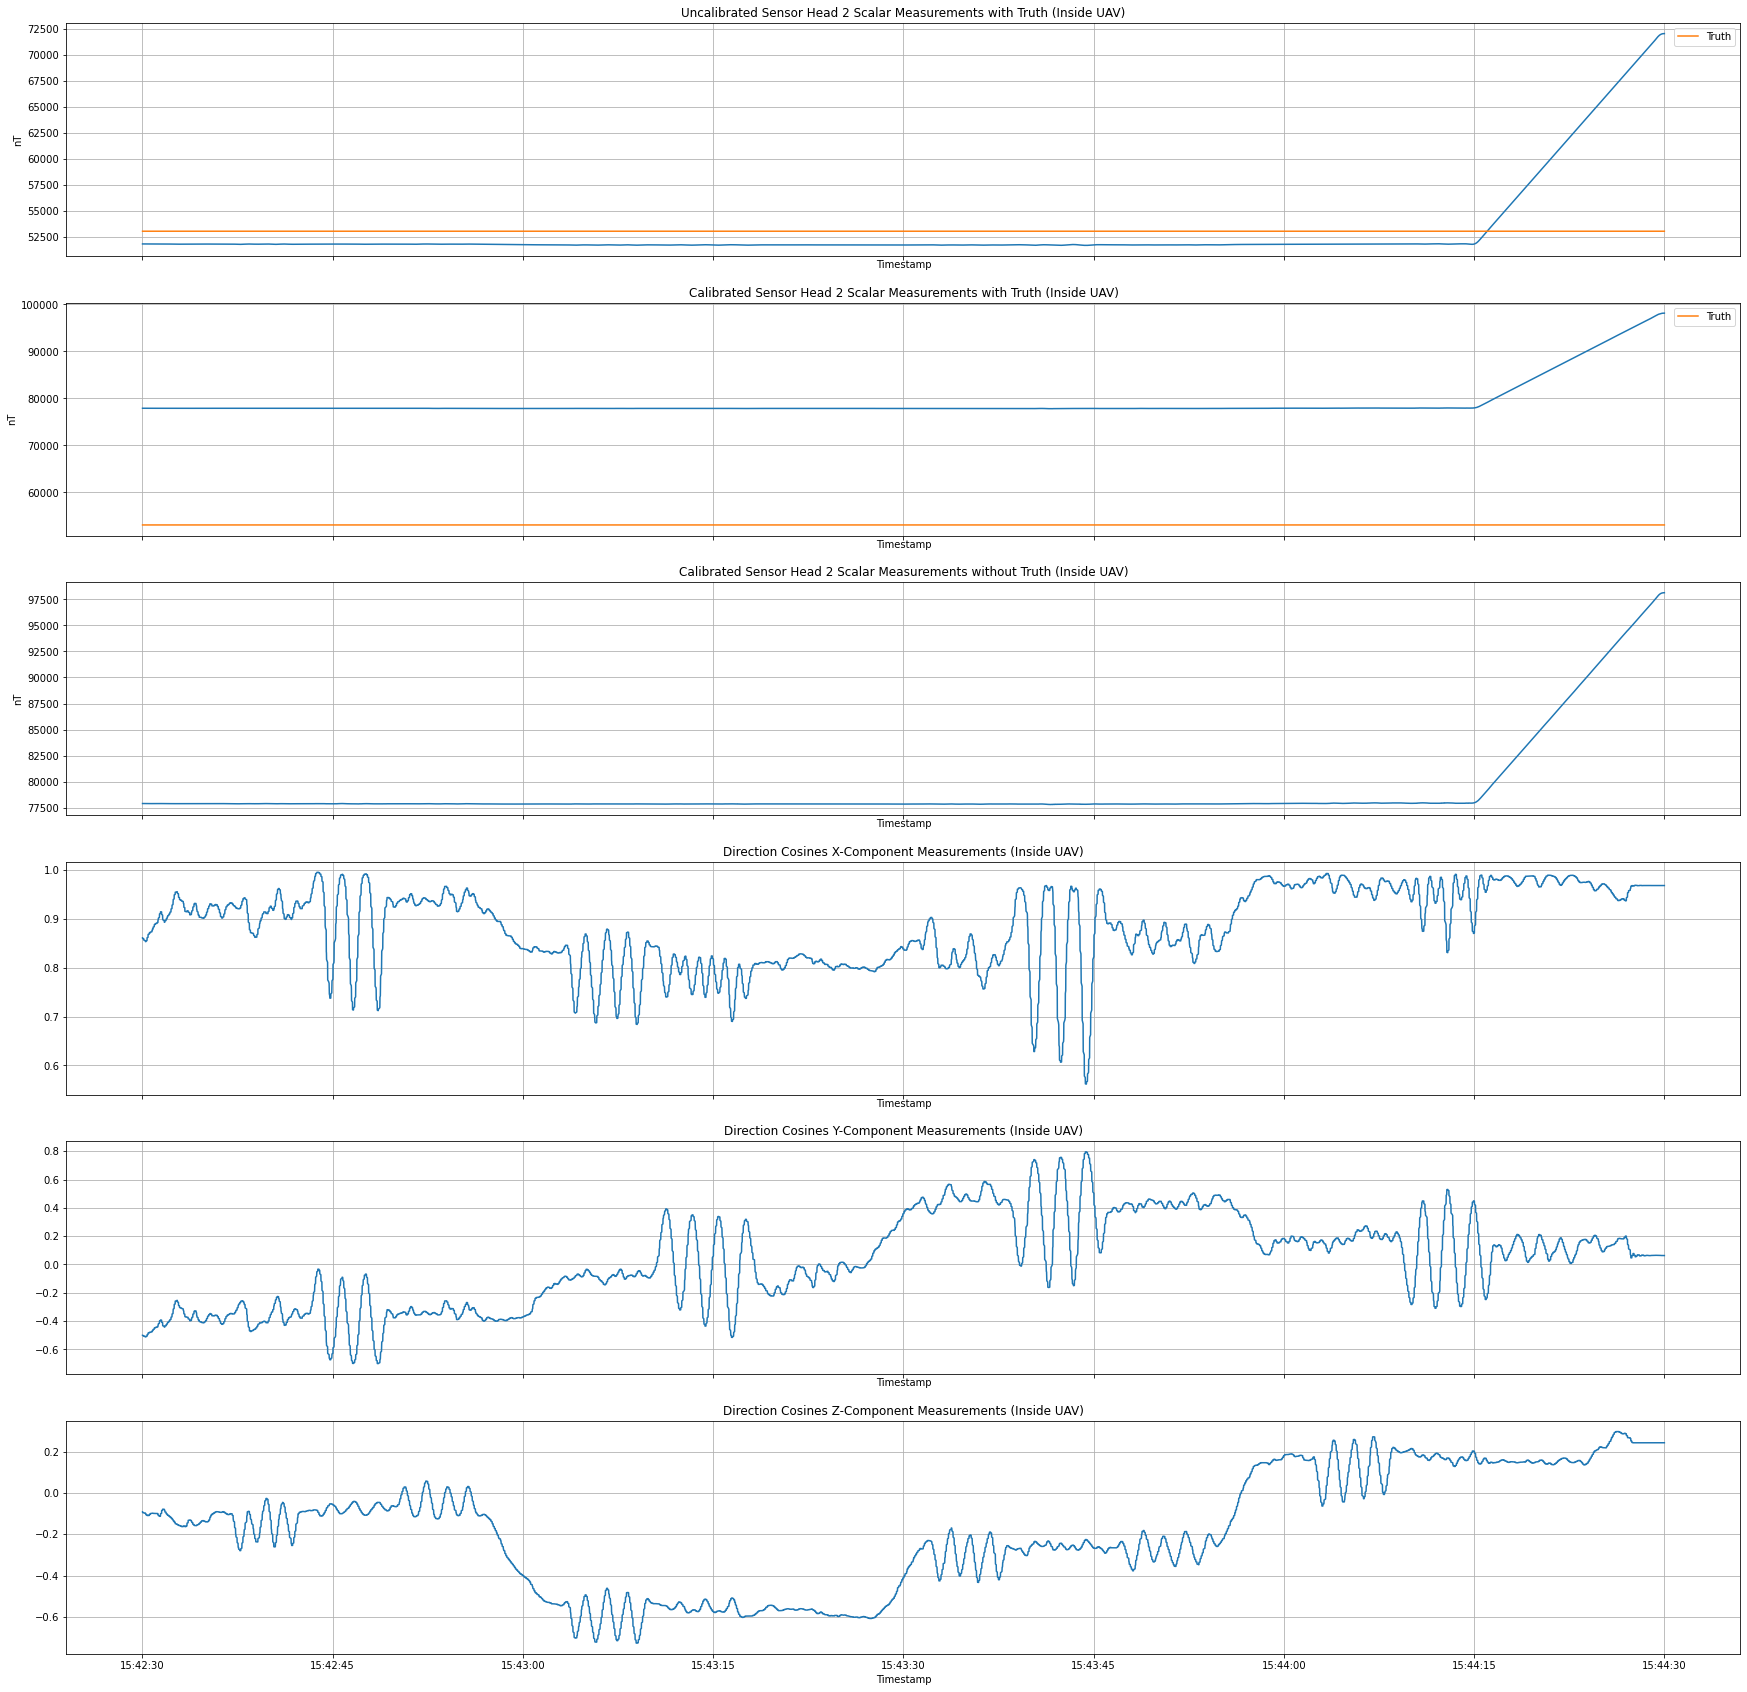

In [16]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Permanent and Induced TL Terms + VMR Vector Sensor)

In [17]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT,
            magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 9.51455083e+02 -1.08094814e+02  5.15643211e+01 -5.52424407e-01
  6.15584496e-03 -2.29753016e-03 -5.12936564e-01  1.78614254e-02
 -5.49312501e-01]
RMSE: 30879.558924171823


# Post-Calibration Plots (Permanent and Induced TL Terms + VMR Vector Sensor)

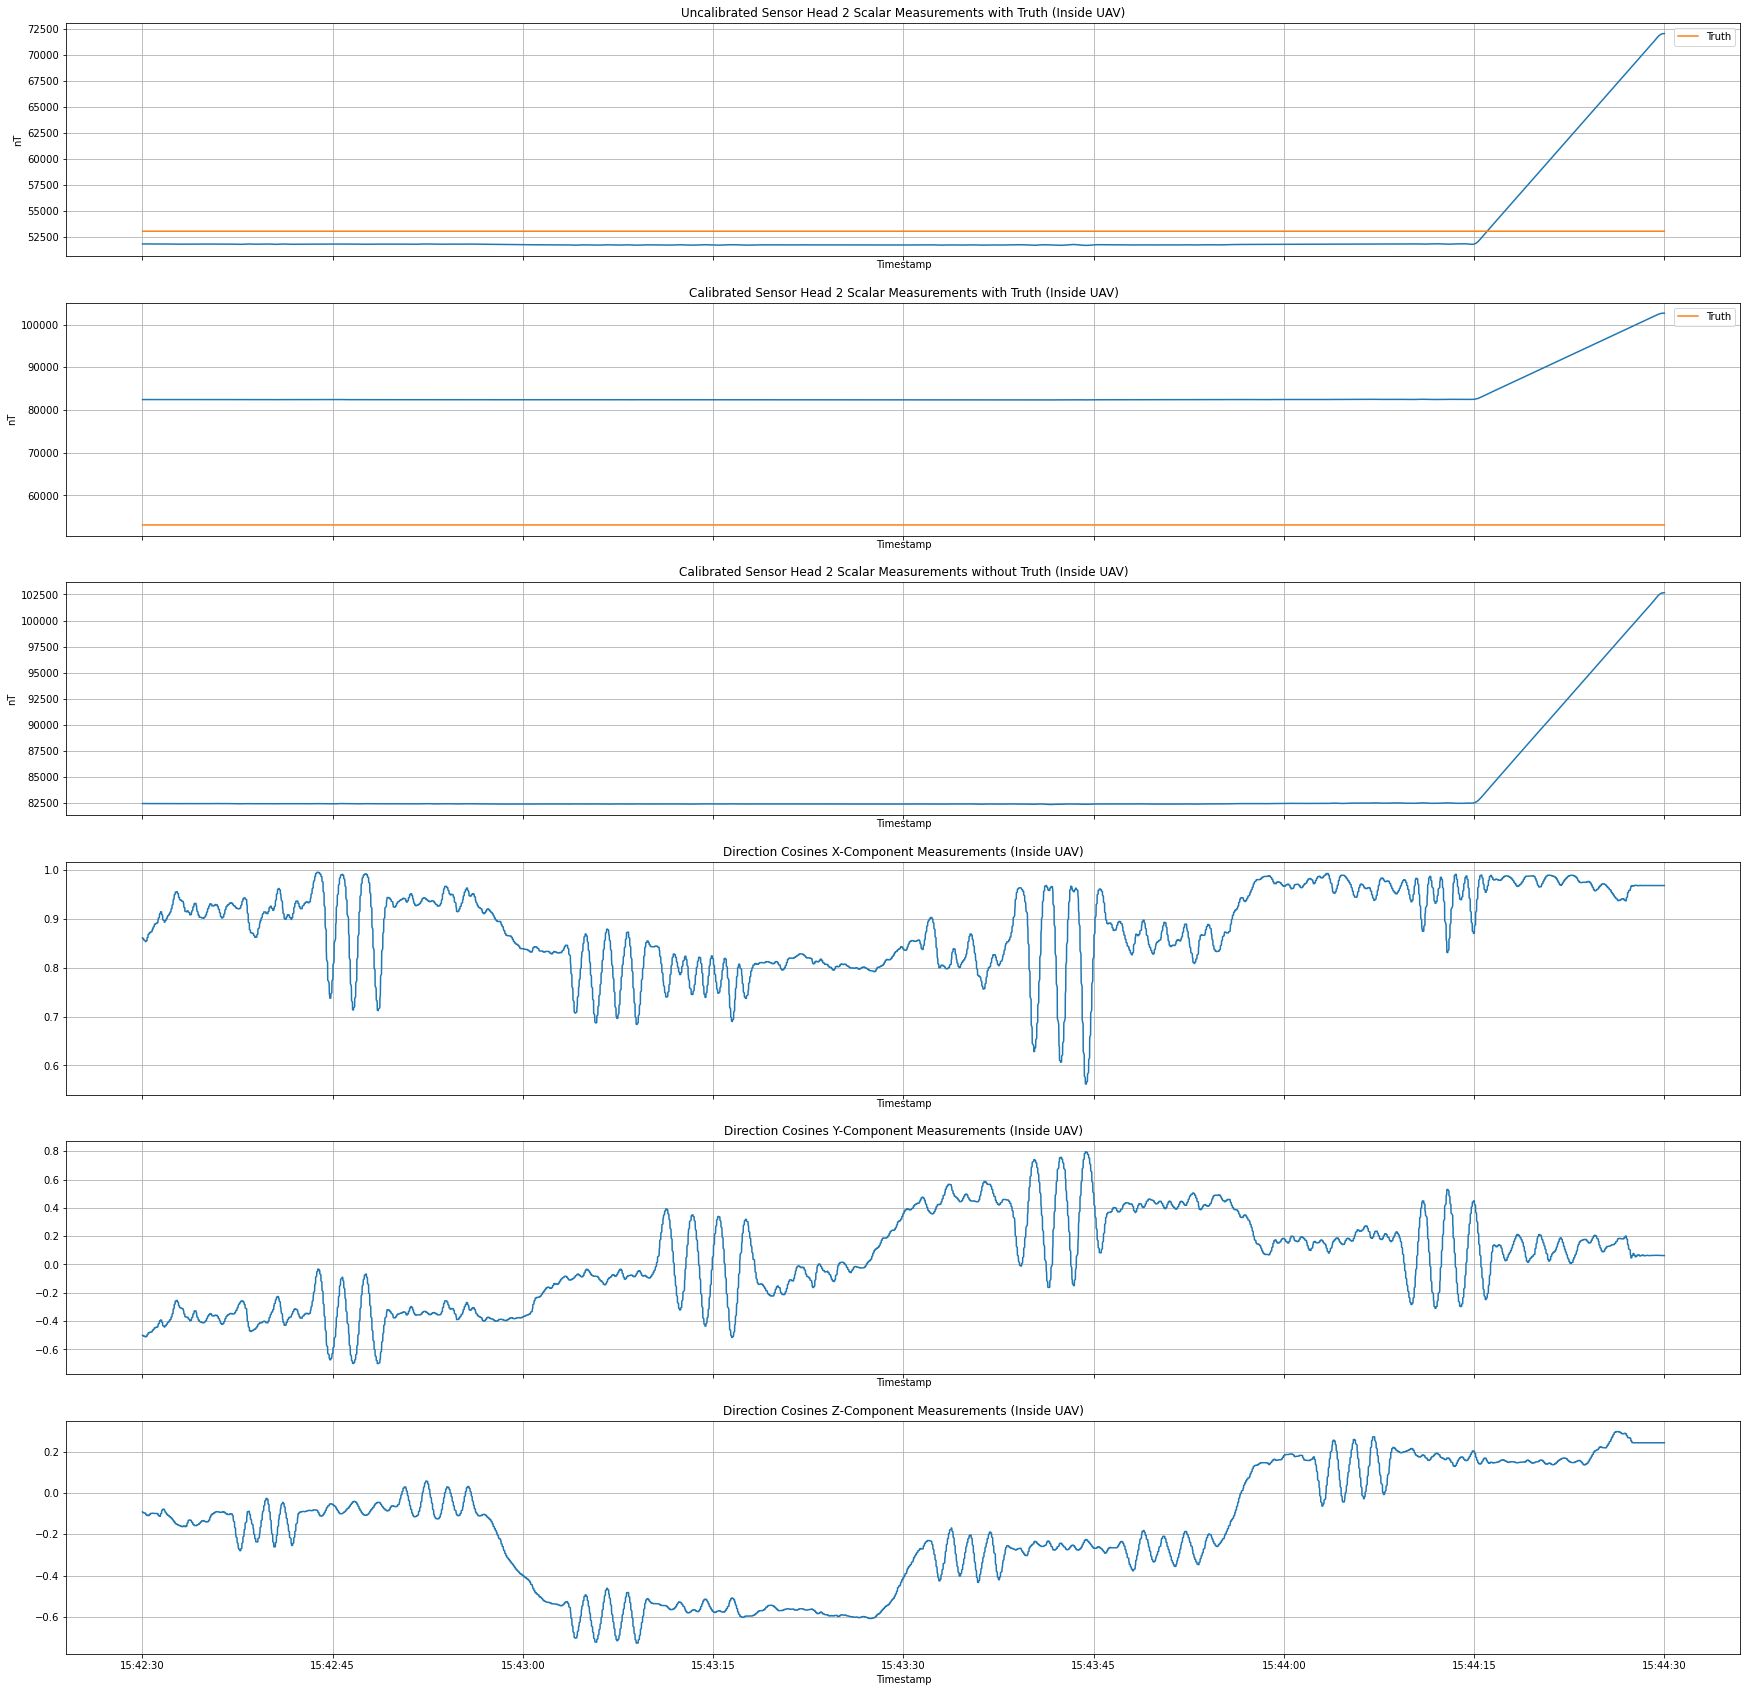

In [18]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Permanent TL Terms + VMR Vector Sensor)

In [19]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 53.21164391 -53.86414114   8.68261074]
RMSE: 3993.3075229006886


# Post-Calibration Plots (Permanent TL Terms + VMR Vector Sensor)

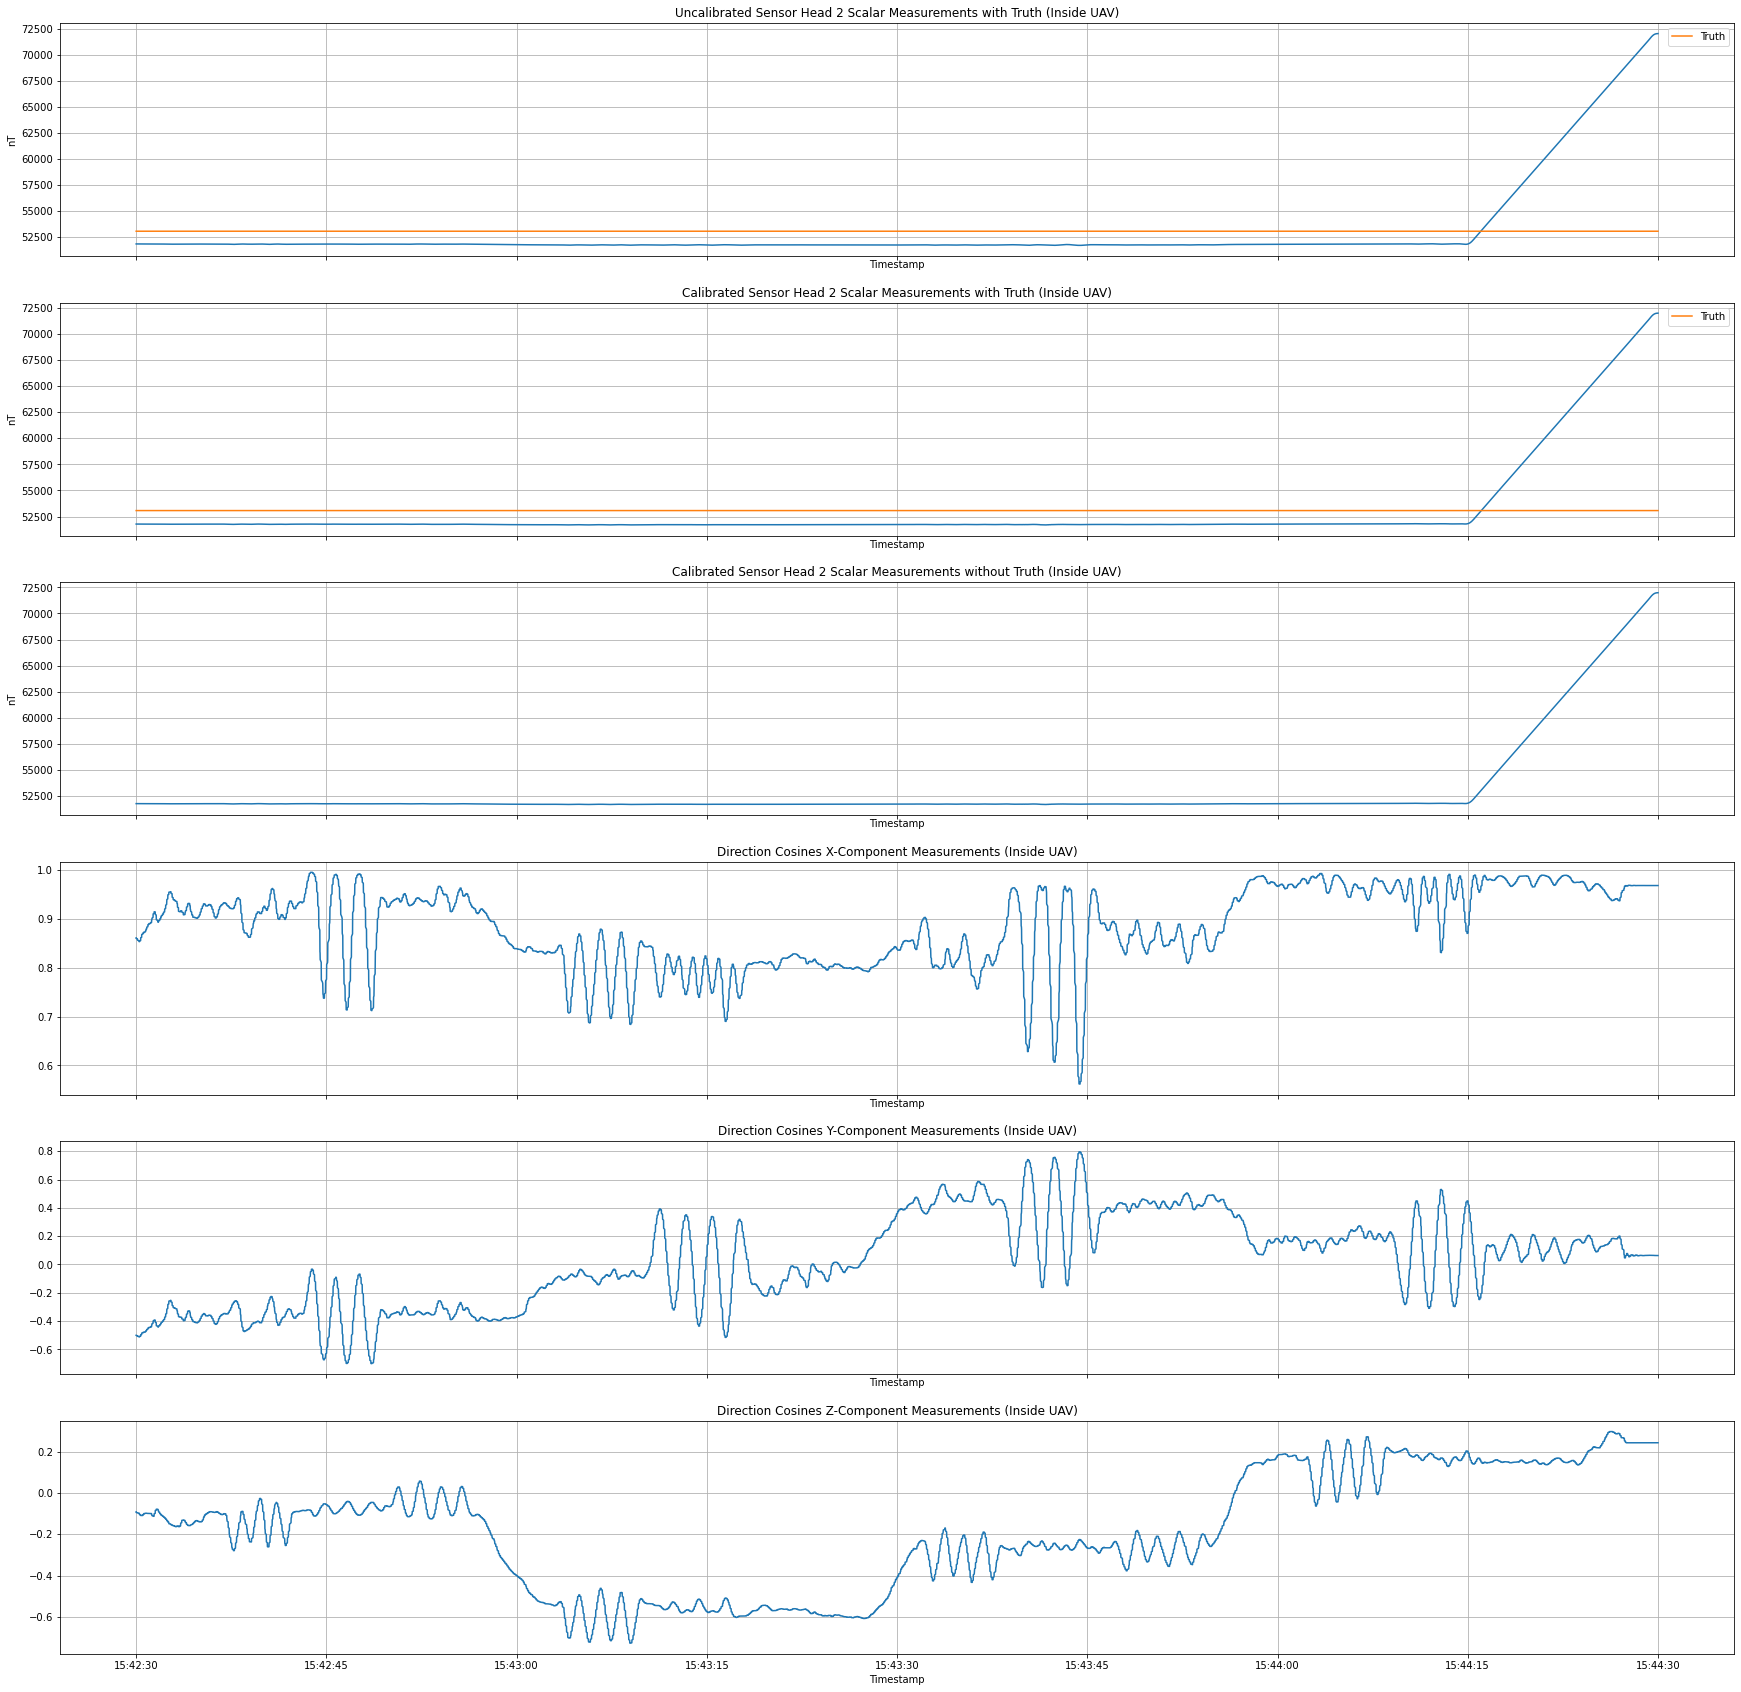

In [20]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Induced TL Terms + VMR Vector Sensor)

In [21]:
tl_terms = [magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 0.02679804 -0.00181478 -0.00066252  0.02495683 -0.00238252  0.02425459]
RMSE: 4275.711751300122


# Post-Calibration Plots (Induced TL Terms + VMR Vector Sensor)

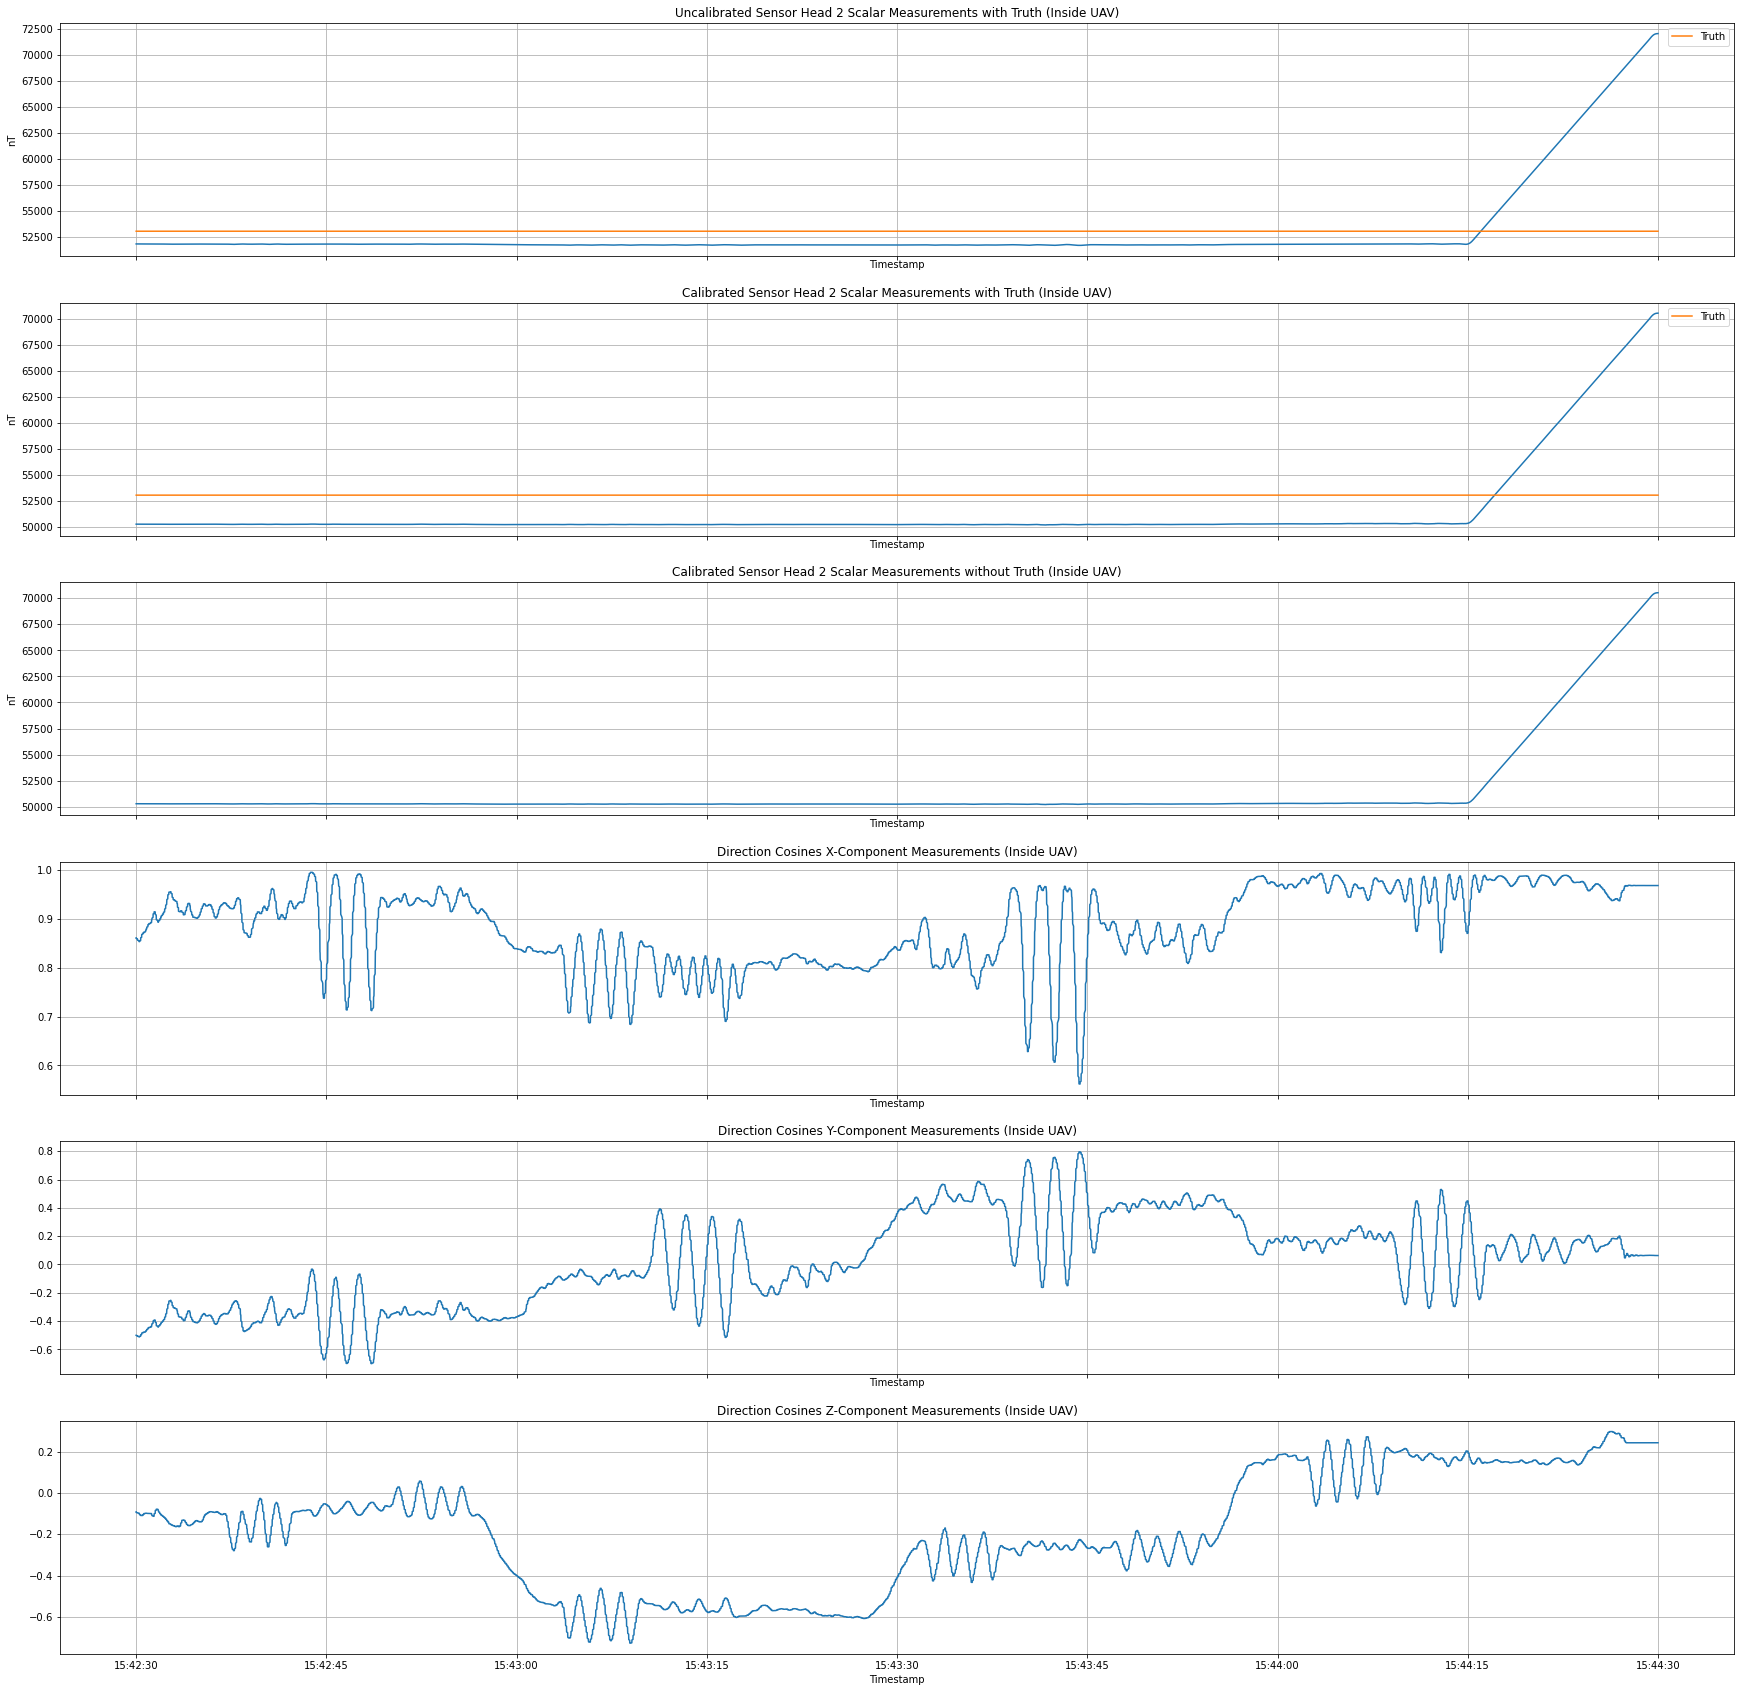

In [22]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Eddy TL Terms + VMR Vector Sensor)

In [23]:
tl_terms = [magtl.TollesLawsonTerms.EDDY]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [-6.01778853e-02  2.33272195e-04  8.45948454e-05  2.32579105e-04
 -5.97097003e-02 -1.36405248e-04 -1.22948285e-03  6.25692793e-04
 -5.92728714e-02]
RMSE: 3994.216963113022


# Post-Calibration Plots (Eddy TL Terms + VMR Vector Sensor)

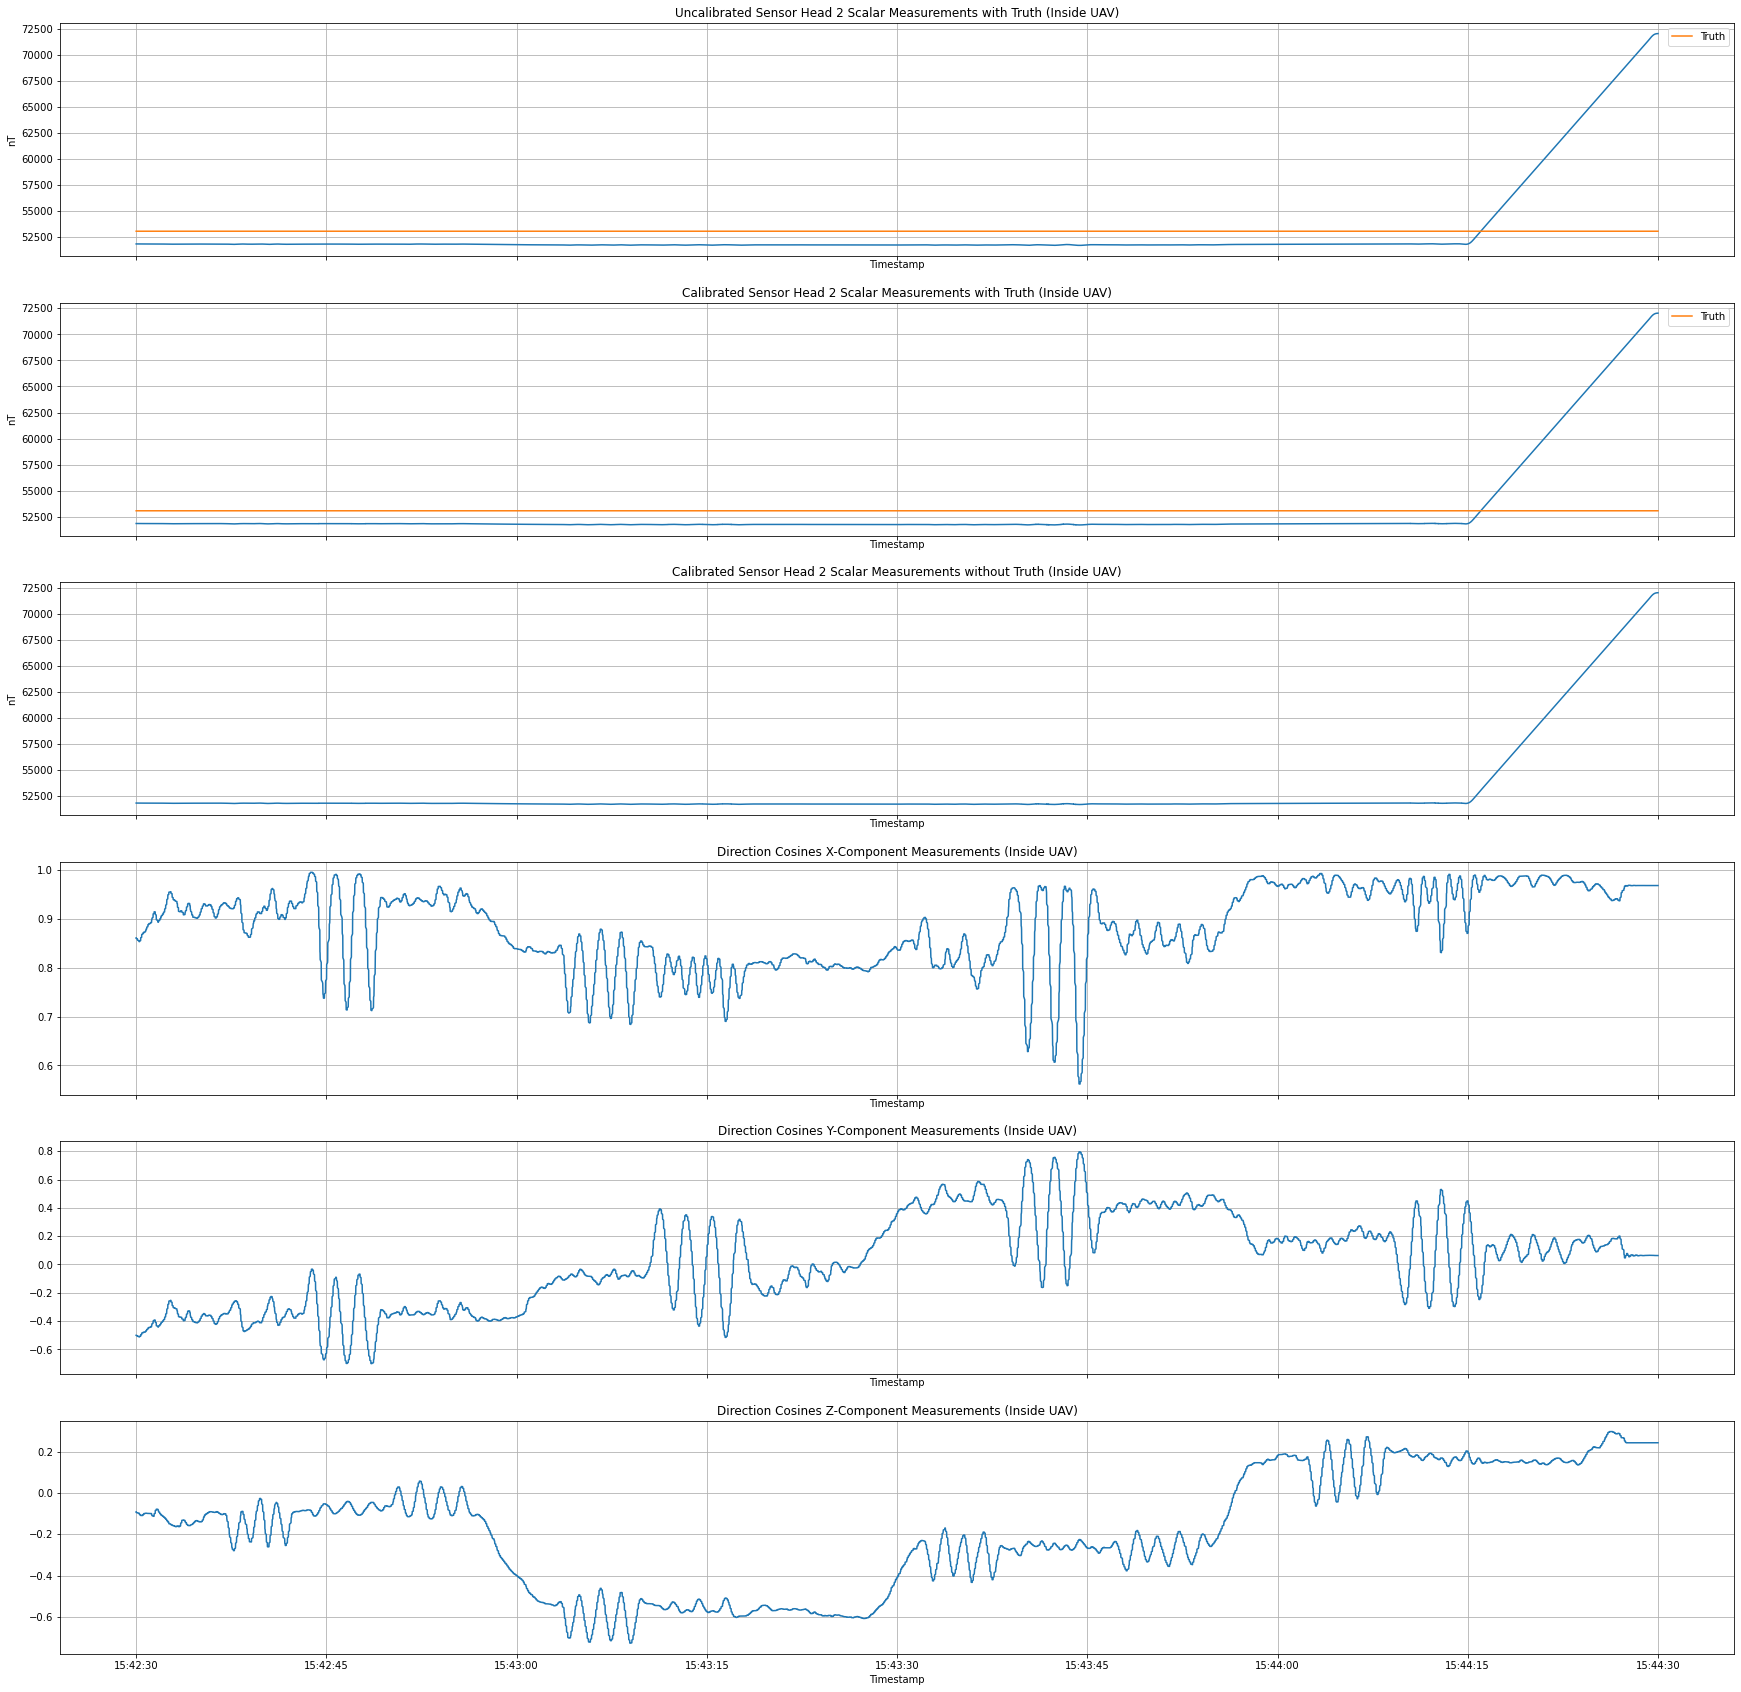

In [24]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)